# Run mulitple deep learning models on GPUs with Amazon SageMaker Multi-model endpoints (MME)

[Amazon SageMaker](https://aws.amazon.com/sagemaker/) multi-model endpoints(MME) provide a scalable and cost-effective way to deploy large number of deep learning models. Previously, customers had limited options to deploy 100s of deep learning models that need accelerated compute with GPUs. Now customers can deploy 1000s of deep learning models behind one SageMaker endpoint. Now, MME will run multiple models on a GPU core, share GPU instances behind an endpoint across multiple models and dynamically load/unload models based on the incoming traffic. With this, customers can significantly save cost and achieve best price performance.

<div class="alert alert-info"> 💡 <strong> Note </strong>
This notebook was tested with the `conda_python3` kernel on an Amazon SageMaker notebook instance of type `g4dn.4xlarge`
</div>

## Amazon SageMaker Multi-Model endpoints with GPU Support

Amazon SageMaker multi-model endpoints with GPU works using [NVIDIA Triton Inference Server](https://github.com/triton-inference-server/server/). NVIDIA Triton Inference Server is open-source inference serving software that simplifies the inference serving process and provides high inference performance. Triton supports all major training and inference frameworks, such as TensorFlow, NVIDIA® TensorRT™, PyTorch, MXNet, Python, ONNX, XGBoost, scikit-learn, RandomForest, OpenVINO, custom C++, and more. It offers dynamic batching, concurrent execution, post-training quantization, optimal model configuration to achieve high performance inference.
When SageMaker receives an invocation request for a particular model, it does the following:

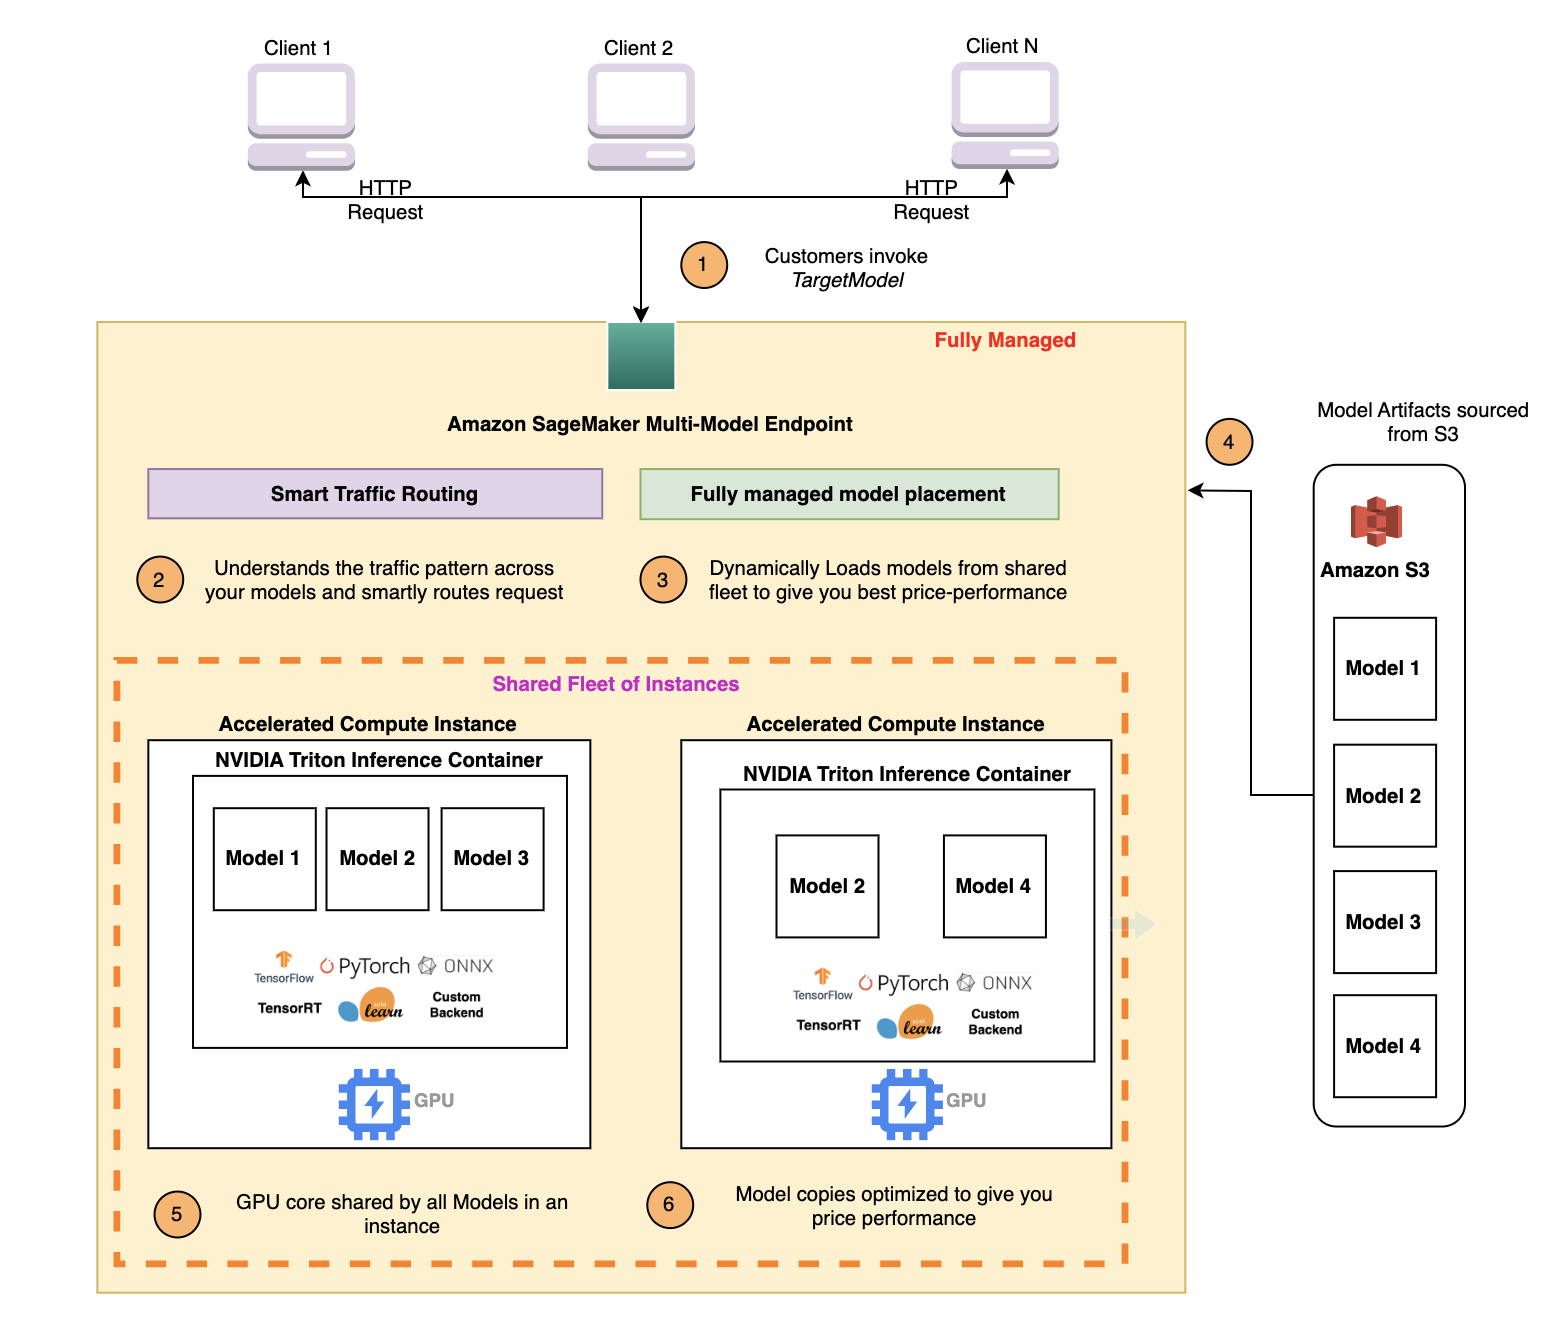

In [1]:
from IPython import display

display.Image("images/mme-gpu.jpg")

## How it works?

1. SageMaker routes traffic to the right instance behind the endpoint where the target model is loaded. SageMaker takes care of model management behind the endpoint, loads model to the container's memory and unloads the model based on the endpoint's traffic pattern.
2. Dynamically loads models from Amazon Simple Storage Service(S3) to the instance’s storage volume. If the invoked models is not available on instance storage volume, the model is downloaded onto instance storage volume. If the instance storage volume reaches capacity, SageMaker deletes any unused models from the storage volume.
3. SageMaker loads the model to NVIDIA Triton container’s memory on GPU accelerated instance and serve the inference request. If the model is already loaded in the container memory, the subsequents requests are served faster as SageMaker does not need to download and load it again.
4. SageMaker takes care of traffic shaping to the MME endpoint, SageMaker continues to routes traffics to the instance where the model is loaded. If the instance resources reach capacity due to high utilization,  SageMaker unloads least used models from the container to free up resource to load more frequently used models.
5. SageMaker MME can horizontally scale using auto-scaling policy, provision additional GPU compute instances based on metrics such as GPU utilization, memory utilization etc to serve spiky traffic to MME endpoints.

In this notebook, we will show you how to use the new features Amazon SageMaker MME with GPU with a computer vision use case. For demonstration purpose, we will use a ResNet-50 convolutional neural network pre-trained model  that can classify images into 1000 categories. We will -

*  Show how to use NVIDIA Triton inference container on SageMaker MME, leverage different model frameworks such and PyTorch and TensorRT. 
*  Walk you through steps to convert ResNet-50 models to optimized TensorRT engine format and deploy it with SageMaker MME. 
* Show how to get insights into instance and invocation metrics using Amazon CloudWatch.

### Installs

Installs the dependencies required to package the model and run inferences using Triton server. Update SageMaker, boto3, awscli etc

In [2]:
!pip install -qU pip awscli boto3 sagemaker
!pip install nvidia-pyindex --quiet
!pip install tritonclient[http] --quiet

### Imports and variables

In [3]:
# imports
import boto3, json, sagemaker, time
from sagemaker import get_execution_role
import numpy as np
from PIL import Image
import tritonclient.http as httpclient

# variables
s3_client = boto3.client("s3")
auto_scaling_client = boto3.client("application-autoscaling")
sample_image_name = "shiba_inu_dog.jpg"
ts = time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

# sagemaker variables
role = get_execution_role()
sm_client = boto3.client(service_name="sagemaker")
runtime_sm_client = boto3.client("sagemaker-runtime")
sagemaker_session = sagemaker.Session(boto_session=boto3.Session())
bucket = sagemaker_session.default_bucket()
prefix = "resnet-mme-gpu"

# endpoint variables
sm_model_name = f"{prefix}-mdl-{ts}"
endpoint_config_name = f"{prefix}-epc-{ts}"
endpoint_name = f"{prefix}-ep-{ts}"
model_data_url = f"s3://{bucket}/{prefix}/"

# account mapping for SageMaker MME Triton Image
account_id_map = {
    "us-east-1": "785573368785",
    "us-east-2": "007439368137",
    "us-west-1": "710691900526",
    "us-west-2": "301217895009",
    "eu-west-1": "802834080501",
    "eu-west-2": "205493899709",
    "eu-west-3": "254080097072",
    "eu-north-1": "601324751636",
    "eu-south-1": "966458181534",
    "eu-central-1": "746233611703",
    "ap-east-1": "110948597952",
    "ap-south-1": "763008648453",
    "ap-northeast-1": "941853720454",
    "ap-northeast-2": "151534178276",
    "ap-southeast-1": "324986816169",
    "ap-southeast-2": "355873309152",
    "cn-northwest-1": "474822919863",
    "cn-north-1": "472730292857",
    "sa-east-1": "756306329178",
    "ca-central-1": "464438896020",
    "me-south-1": "836785723513",
    "af-south-1": "774647643957",
}

region = boto3.Session().region_name
if region not in account_id_map.keys():
    raise ("UNSUPPORTED REGION")

base = "amazonaws.com.cn" if region.startswith("cn-") else "amazonaws.com"
mme_triton_image_uri = (
    "{account_id}.dkr.ecr.{region}.{base}/sagemaker-tritonserver:22.07-py3".format(
        account_id=account_id_map[region], region=region, base=base
    )
)

In [4]:
# mme_triton_image_uri = "850464037171.dkr.ecr.ap-south-1.amazonaws.com/tritonserver:22.07-py3"

### Creating Model Artifacts

This section presents overview of steps to prepare ResNet-50 pre-trained model to be deployed on SageMaker MME using Triton Inference server model configurations. 


<div class="alert alert-info"> 💡 <strong> Note </strong>
We are demonstrating deployment with 2 models. However, customers can prepare and 100s of models. The models may or may not share the same framework.
</div>

#### Prepare PyTorch Model 

`generate_model_pytorch.sh` file in the `workspace` directory contains scripts to generate a PyTorch model. First, we load a pre-trained ResNet50 model using torchvision models package. We save the model as model.pt file in TorchScript optimized and serialized format. TorchScript needs an example inputs to do a model forward pass, so we pass one instance of a RGB image with 3 color channels of dimension 224X224.

In [5]:
!docker run --gpus=all --rm -it \
            -v `pwd`/workspace:/workspace nvcr.io/nvidia/pytorch:22.07-py3 \
            /bin/bash generate_model_pytorch.sh


== PyTorch ==

NVIDIA Release 22.07 (build 40241807)
PyTorch Version 1.13.0a0+08820cb

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This 

#### PyTorch Model Respository

The model repository contains model to serve, in our case it will be the model.pt and configuration file with input/output specifications and metadata.

```
resnet
├── 1
│   └── model.pt
└── config.pbtxt
```

#### PyTorch Model configuration

Model configuration file config.pbtxt must specify name of the model(resnet), the platform and backend properties (pytorch_libtorch), max_batch_size(128) and the input and output tensors along with the data type(TYPE_FP32) information. Additionally, you can specify instance_group and dynamic_batching properties to achieve high performance inference.

In [6]:
!mkdir -p triton-serve-pt/resnet/

In [7]:
%%writefile triton-serve-pt/resnet/config.pbtxt
name: "resnet"
platform: "pytorch_libtorch"
max_batch_size: 128
input {
  name: "INPUT__0"
  data_type: TYPE_FP32
  dims: 3
  dims: 224
  dims: 224
}
output {
  name: "OUTPUT__0"
  data_type: TYPE_FP32
  dims: 1000
}

Writing triton-serve-pt/resnet/config.pbtxt


#### Prepare TensorRT Model

1. We export the pre-trained ResNet model into an ONNX file, which runs the model once to trace its execution and then export the traced model to the specified file. It is one of the better options in terms model conversion and deployment when converting using ONNX.

2. We use `trtexec` to automatically convert ONNX model to TensorRT plan. As ONNX is framework agnostic it works with models in TF, PyTorch and more. You will export the weights of your model from the framework and load them into your TensorRT network.


In this step, we load pre-trained ResNet50 model from torch and convert to onnx representation using torch onnx exporter. Once onnx model is created, we use TensorRT trtexec command to create the model plan to be hosted with Triton. The script for exporting this model can be found [here](./workspace/generate_model_trt.sh). This is run as part of the `generate_model_trt.sh` script from the below cell.

In [8]:
!docker run --gpus=all --rm -it \
            -v `pwd`/workspace:/workspace nvcr.io/nvidia/pytorch:22.07-py3 \
            /bin/bash generate_model_trt.sh


== PyTorch ==

NVIDIA Release 22.07 (build 40241807)
PyTorch Version 1.13.0a0+08820cb

Container image Copyright (c) 2022, NVIDIA CORPORATION & AFFILIATES. All rights reserved.

Copyright (c) 2014-2022 Facebook Inc.
Copyright (c) 2011-2014 Idiap Research Institute (Ronan Collobert)
Copyright (c) 2012-2014 Deepmind Technologies    (Koray Kavukcuoglu)
Copyright (c) 2011-2012 NEC Laboratories America (Koray Kavukcuoglu)
Copyright (c) 2011-2013 NYU                      (Clement Farabet)
Copyright (c) 2006-2010 NEC Laboratories America (Ronan Collobert, Leon Bottou, Iain Melvin, Jason Weston)
Copyright (c) 2006      Idiap Research Institute (Samy Bengio)
Copyright (c) 2001-2004 Idiap Research Institute (Ronan Collobert, Samy Bengio, Johnny Mariethoz)
Copyright (c) 2015      Google Inc.
Copyright (c) 2015      Yangqing Jia
Copyright (c) 2013-2016 The Caffe contributors
All rights reserved.

Various files include modifications (c) NVIDIA CORPORATION & AFFILIATES.  All rights reserved.

This 

[10/18/2022-15:53:38] [I] [TRT] [MemUsageChange] Init CUDA: CPU +311, GPU +0, now: CPU 319, GPU 241 (MiB)
[10/18/2022-15:53:39] [I] [TRT] [MemUsageChange] Init builder kernel library: CPU +207, GPU +68, now: CPU 545, GPU 309 (MiB)
[10/18/2022-15:53:39] [I] Start parsing network model
[10/18/2022-15:53:40] [I] [TRT] ----------------------------------------------------------------
[10/18/2022-15:53:40] [I] [TRT] Input filename:   model.onnx
[10/18/2022-15:53:40] [I] [TRT] ONNX IR version:  0.0.6
[10/18/2022-15:53:40] [I] [TRT] Opset version:    11
[10/18/2022-15:53:40] [I] [TRT] Producer name:    pytorch
[10/18/2022-15:53:40] [I] [TRT] Producer version: 1.13.0
[10/18/2022-15:53:40] [I] [TRT] Domain:           
[10/18/2022-15:53:40] [I] [TRT] Model version:    0
[10/18/2022-15:53:40] [I] [TRT] Doc string:       
[10/18/2022-15:53:40] [I] [TRT] ----------------------------------------------------------------
[10/18/2022-15:53:40] [V] [TRT] Plugin creator already registered - ::BatchTilePlu

[10/18/2022-15:53:40] [V] [TRT] Using kernel: (3, 3), strides: (2, 2), prepadding: (1, 1), postpadding: (1, 1), dilations: (1, 1), numOutputs: 512
[10/18/2022-15:53:40] [V] [TRT] Convolution output dimensions: (-1, 512, 7, 7)
[10/18/2022-15:53:40] [V] [TRT] Registering tensor: input.348 for ONNX tensor: input.348
[10/18/2022-15:53:40] [V] [TRT] Conv_99 [Conv] outputs: [input.348 -> (-1, 512, 7, 7)[FLOAT]], 
[10/18/2022-15:53:40] [V] [TRT] Parsing node: Relu_100 [Relu]
[10/18/2022-15:53:40] [V] [TRT] Searching for input: input.348
[10/18/2022-15:53:40] [V] [TRT] Relu_100 [Relu] inputs: [input.348 -> (-1, 512, 7, 7)[FLOAT]], 
[10/18/2022-15:53:40] [V] [TRT] Registering layer: Relu_100 for ONNX node: Relu_100
[10/18/2022-15:53:40] [V] [TRT] Registering tensor: onnx::Conv_466 for ONNX tensor: onnx::Conv_466
[10/18/2022-15:53:40] [V] [TRT] Relu_100 [Relu] outputs: [onnx::Conv_466 -> (-1, 512, 7, 7)[FLOAT]], 
[10/18/2022-15:53:40] [V] [TRT] Parsing node: Conv_101 [Conv]
[10/18/2022-15:53:40]

[10/18/2022-15:53:40] [V] [TRT] After tensor merging: 57 layers
[10/18/2022-15:53:41] [V] [TRT] After vertical fusions: 57 layers
[10/18/2022-15:53:41] [V] [TRT] After dupe layer removal: 57 layers
[10/18/2022-15:53:41] [V] [TRT] After final dead-layer removal: 57 layers
[10/18/2022-15:53:41] [V] [TRT] After tensor merging: 57 layers
[10/18/2022-15:53:41] [V] [TRT] After slice removal: 57 layers
[10/18/2022-15:53:41] [V] [TRT] After concat removal: 57 layers
[10/18/2022-15:53:41] [V] [TRT] Trying to split Reshape and strided tensor
[10/18/2022-15:53:41] [V] [TRT] Graph construction and optimization completed in 1.16377 seconds.
[10/18/2022-15:53:41] [V] [TRT] Using cublasLt as a tactic source
[10/18/2022-15:53:41] [I] [TRT] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +499, GPU +216, now: CPU 1158, GPU 533 (MiB)
[10/18/2022-15:53:41] [V] [TRT] Using cuDNN as a tactic source
[10/18/2022-15:53:42] [I] [TRT] [MemUsageChange] Init cuDNN: CPU +116, GPU +52, now: CPU 1274, GPU 585 (MiB)
[10/18

[10/18/2022-15:53:43] [V] [TRT] Tactic: 0x00000000000003ea Time: 3.48773
[10/18/2022-15:53:43] [V] [TRT] Tactic: 0x0000000000000000 Time: 4.09536
[10/18/2022-15:53:43] [V] [TRT] Fastest Tactic: 0x00000000000003e8 Time: 2.59103
[10/18/2022-15:53:43] [V] [TRT] *************** Autotuning Reformat: Half(802816,12544,112,1) -> Half(401408,12544:2,112,1) ***************
[10/18/2022-15:53:43] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::MaxPool_323 -> <out>) (Reformat)
[10/18/2022-15:53:43] [V] [TRT] Tactic: 0x00000000000003e8 Time: 2.62338
[10/18/2022-15:53:43] [V] [TRT] Tactic: 0x00000000000003ea Time: 2.64834
[10/18/2022-15:53:43] [V] [TRT] Tactic: 0x0000000000000000 Time: 2.34279
[10/18/2022-15:53:43] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 2.34279
[10/18/2022-15:53:43] [V] [TRT] *************** Autotuning Reformat: Half(802816,12544,112,1) -> Half(100352,1:8,896,8) ***************
[10/18/2022-15:53:43] [V] [TRT] --------------- Timing Runner: Optimizer Ref

[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.656823
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.467237
[10/18/2022-15:53:44] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.467237
[10/18/2022-15:53:44] [V] [TRT] *************** Autotuning Reformat: Half(100352,3136:2,56,1) -> Float(200704,3136,56,1) ***************
[10/18/2022-15:53:44] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> input.8) (Reformat)
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.765074
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003ea Time: 1.02978
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.644187
[10/18/2022-15:53:44] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.644187
[10/18/2022-15:53:44] [V] [TRT] *************** Autotuning Reformat: Half(100352,3136:2,56,1) -> Float(200704,1,3584,64) ***************
[10/18/2022-15:53:44] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<

[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003e8 Time: 1.45813
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.841938
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x0000000000000000 Time: 1.47596
[10/18/2022-15:53:44] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 0.841938
[10/18/2022-15:53:44] [V] [TRT] *************** Autotuning Reformat: Float(200704,1,3584,64) -> Half(25088,1:8,448,8) ***************
[10/18/2022-15:53:44] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(input.8 -> <out>) (Reformat)
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.778533
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.609527
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.778121
[10/18/2022-15:53:44] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 0.609527
[10/18/2022-15:53:44] [V] [TRT] *************** Autotuning Reformat: Half(200704,3136,56,1) -> Float(200704,3136,56,1) ***************
[10/18/2022-15

[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003e8 Time: 5.57557
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003ea Time: 4.84139
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x0000000000000000 Time: 5.30403
[10/18/2022-15:53:44] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 4.84139
[10/18/2022-15:53:44] [V] [TRT] *************** Autotuning Reformat: Float(802816,3136,56,1) -> Half(802816,3136,56,1) ***************
[10/18/2022-15:53:44] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Add_505 -> <out>) (Reformat)
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003e8 Time: 2.49622
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x00000000000003ea Time: 3.08363
[10/18/2022-15:53:44] [V] [TRT] Tactic: 0x0000000000000000 Time: 3.12237
[10/18/2022-15:53:44] [V] [TRT] Fastest Tactic: 0x00000000000003e8 Time: 2.49622
[10/18/2022-15:53:44] [V] [TRT] *************** Autotuning Reformat: Float(802816,3136,56,1) -> Half(401408,3136:2,56,1) ***************
[10/18/2022

[10/18/2022-15:53:46] [V] [TRT] Tactic: 0x00000000000003e8 Time: 3.43248
[10/18/2022-15:53:46] [V] [TRT] Tactic: 0x00000000000003ea Time: 2.06024
[10/18/2022-15:53:46] [V] [TRT] Tactic: 0x0000000000000000 Time: 1.9851
[10/18/2022-15:53:46] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 1.9851
[10/18/2022-15:53:46] [V] [TRT] *************** Autotuning Reformat: Half(100352,1:8,1792,32) -> Float(802816,3136,56,1) ***************
[10/18/2022-15:53:46] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Add_505 -> <out>) (Reformat)
[10/18/2022-15:53:46] [V] [TRT] Tactic: 0x00000000000003e8 Time: 5.74293
[10/18/2022-15:53:46] [V] [TRT] Tactic: 0x00000000000003ea Time: 4.07993
[10/18/2022-15:53:46] [V] [TRT] Tactic: 0x0000000000000000 Time: 3.01024
[10/18/2022-15:53:46] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 3.01024
[10/18/2022-15:53:46] [V] [TRT] *************** Autotuning Reformat: Half(100352,1:8,1792,32) -> Float(802816,1,14336,256) ***************
[10/18/20

[10/18/2022-15:53:47] [V] [TRT] Tactic: 0x00000000000003e8 Time: 3.05114
[10/18/2022-15:53:47] [V] [TRT] Tactic: 0x00000000000003ea Time: 2.78497
[10/18/2022-15:53:47] [V] [TRT] Tactic: 0x0000000000000000 Time: 2.38432
[10/18/2022-15:53:47] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 2.38432
[10/18/2022-15:53:47] [V] [TRT] *************** Autotuning Reformat: Half(802816,3136,56,1) -> Half(100352,1:8,1792,32) ***************
[10/18/2022-15:53:47] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> input.36) (Reformat)
[10/18/2022-15:53:47] [V] [TRT] Tactic: 0x00000000000003e8 Time: 4.61093
[10/18/2022-15:53:47] [V] [TRT] Tactic: 0x00000000000003ea Time: 2.79808
[10/18/2022-15:53:47] [V] [TRT] Tactic: 0x0000000000000000 Time: 2.0055
[10/18/2022-15:53:47] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 2.0055
[10/18/2022-15:53:47] [V] [TRT] *************** Autotuning Reformat: Half(401408,3136:2,56,1) -> Float(802816,3136,56,1) ***************
[10/18/2022-15:53:

[10/18/2022-15:53:48] [V] [TRT] Tactic: 0x00000000000003ea Time: 2.38949
[10/18/2022-15:53:48] [V] [TRT] Tactic: 0x0000000000000000 Time: 2.57052
[10/18/2022-15:53:48] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 2.38949
[10/18/2022-15:53:48] [V] [TRT] *************** Autotuning Reformat: Float(401408,3136,56,1) -> Half(401408,3136,56,1) ***************
[10/18/2022-15:53:48] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Conv_359 -> <out>) (Reformat)
[10/18/2022-15:53:48] [V] [TRT] Tactic: 0x00000000000003e8 Time: 1.20514
[10/18/2022-15:53:48] [V] [TRT] Tactic: 0x00000000000003ea Time: 1.54475
[10/18/2022-15:53:48] [V] [TRT] Tactic: 0x0000000000000000 Time: 1.56346
[10/18/2022-15:53:48] [V] [TRT] Fastest Tactic: 0x00000000000003e8 Time: 1.20514
[10/18/2022-15:53:48] [V] [TRT] *************** Autotuning Reformat: Float(401408,3136,56,1) -> Half(200704,3136:2,56,1) ***************
[10/18/2022-15:53:48] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(o

[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x00000000000003e8 Time: 2.69019
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x00000000000003ea Time: 2.00833
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x0000000000000000 Time: 1.4436
[10/18/2022-15:53:49] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 1.4436
[10/18/2022-15:53:49] [V] [TRT] *************** Autotuning Reformat: Half(50176,1:8,896,16) -> Float(401408,1,7168,128) ***************
[10/18/2022-15:53:49] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Conv_359 -> <out>) (Reformat)
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x00000000000003e8 Time: 1.53203
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x00000000000003ea Time: 1.52279
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x0000000000000000 Time: 1.52278
[10/18/2022-15:53:49] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 1.52278
[10/18/2022-15:53:49] [V] [TRT] *************** Autotuning Reformat: Half(50176,1:8,896,16) -> Half(401408,3136,56,1) ***************
[10/18/2022-15

[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.715726
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.289061
[10/18/2022-15:53:49] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.289061
[10/18/2022-15:53:49] [V] [TRT] *************** Autotuning Reformat: Half(50176,784:2,28,1) -> Half(12544,1:8,448,16) ***************
[10/18/2022-15:53:49] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Conv_362 -> <out>) (Reformat)
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.425161
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.242386
[10/18/2022-15:53:49] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.232192
[10/18/2022-15:53:49] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.232192
[10/18/2022-15:53:49] [V] [TRT] *************** Autotuning Reformat: Half(12544,1:8,448,16) -> Float(100352,784,28,1) ***************
[10/18/2022-15:53:49] [V] [TRT] --------------- Timing Runner: Optimizer Reforma

[10/18/2022-15:53:50] [V] [TRT] Tactic: 0x0000000000000000 Time: 2.62544
[10/18/2022-15:53:50] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 2.62544
[10/18/2022-15:53:50] [V] [TRT] *************** Autotuning Reformat: Float(401408,1,14336,512) -> Half(401408,784,28,1) ***************
[10/18/2022-15:53:50] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Add_535 -> <out>) (Reformat)
[10/18/2022-15:53:50] [V] [TRT] Tactic: 0x00000000000003e8 Time: 2.4424
[10/18/2022-15:53:50] [V] [TRT] Tactic: 0x00000000000003ea Time: 1.77816
[10/18/2022-15:53:50] [V] [TRT] Tactic: 0x0000000000000000 Time: 2.54656
[10/18/2022-15:53:50] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 1.77816
[10/18/2022-15:53:50] [V] [TRT] *************** Autotuning Reformat: Float(401408,1,14336,512) -> Half(200704,784:2,28,1) ***************
[10/18/2022-15:53:50] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Add_535 -> <out>) (Reformat)
[10/18/2022-15:53:50] [V] [TRT] Tactic:

[10/18/2022-15:53:50] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.916677
[10/18/2022-15:53:50] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.916677
[10/18/2022-15:53:50] [V] [TRT] =============== Computing reformatting costs
[10/18/2022-15:53:50] [V] [TRT] *************** Autotuning Reformat: Float(401408,784,28,1) -> Float(401408,1,14336,512) ***************
[10/18/2022-15:53:50] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> input.112) (Reformat)
[10/18/2022-15:53:50] [V] [TRT] Tactic: 0x00000000000003e8 Time: 2.76159
[10/18/2022-15:53:50] [V] [TRT] Tactic: 0x00000000000003ea Time: 2.51307
[10/18/2022-15:53:50] [V] [TRT] Tactic: 0x0000000000000000 Time: 2.61247
[10/18/2022-15:53:50] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 2.51307
[10/18/2022-15:53:50] [V] [TRT] *************** Autotuning Reformat: Float(401408,784,28,1) -> Half(401408,784,28,1) ***************
[10/18/2022-15:53:50] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in

[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x00000000000003e8 Time: 1.70614
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.990062
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.955451
[10/18/2022-15:53:51] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.955451
[10/18/2022-15:53:51] [V] [TRT] *************** Autotuning Reformat: Half(50176,1:8,1792,64) -> Float(401408,784,28,1) ***************
[10/18/2022-15:53:51] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> input.112) (Reformat)
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x00000000000003e8 Time: 2.71567
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x00000000000003ea Time: 2.16999
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x0000000000000000 Time: 1.48365
[10/18/2022-15:53:51] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 1.48365
[10/18/2022-15:53:51] [V] [TRT] *************** Autotuning Reformat: Half(50176,1:8,1792,64) -> Float(401408,1,14336,512) ***************
[10/18/2022-

[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.792283
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.785856
[10/18/2022-15:53:51] [V] [TRT] Fastest Tactic: 0x00000000000003e8 Time: 0.601166
[10/18/2022-15:53:51] [V] [TRT] *************** Autotuning Reformat: Float(200704,784,28,1) -> Half(100352,784:2,28,1) ***************
[10/18/2022-15:53:51] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Conv_401 -> <out>) (Reformat)
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.814811
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.880347
[10/18/2022-15:53:51] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.635182
[10/18/2022-15:53:51] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.635182
[10/18/2022-15:53:51] [V] [TRT] *************** Autotuning Reformat: Float(200704,784,28,1) -> Half(25088,1:8,896,32) ***************
[10/18/2022-15:53:51] [V] [TRT] --------------- Timing Runner: Optimizer Reform

[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003ea Time: 1.07662
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.722304
[10/18/2022-15:53:52] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.722304
[10/18/2022-15:53:52] [V] [TRT] *************** Autotuning Reformat: Half(25088,1:8,896,32) -> Float(200704,1,7168,256) ***************
[10/18/2022-15:53:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Conv_401 -> <out>) (Reformat)
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.80176
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.776133
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.768
[10/18/2022-15:53:52] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.768
[10/18/2022-15:53:52] [V] [TRT] *************** Autotuning Reformat: Half(25088,1:8,896,32) -> Half(200704,784,28,1) ***************
[10/18/2022-15:53:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx:

[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.302459
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.166953
[10/18/2022-15:53:52] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.166953
[10/18/2022-15:53:52] [V] [TRT] *************** Autotuning Reformat: Half(25088,196:2,14,1) -> Float(50176,1,3584,256) ***************
[10/18/2022-15:53:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Conv_404 -> <out>) (Reformat)
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.22085
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.189669
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.220306
[10/18/2022-15:53:52] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 0.189669
[10/18/2022-15:53:52] [V] [TRT] *************** Autotuning Reformat: Half(25088,196:2,14,1) -> Half(50176,196,14,1) ***************
[10/18/2022-15:53:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(

[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.931826
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.635849
[10/18/2022-15:53:52] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.635849
[10/18/2022-15:53:52] [V] [TRT] *************** Autotuning Reformat: Float(200704,196,14,1) -> Half(25088,1:8,1792,128) ***************
[10/18/2022-15:53:52] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Add_574 -> <out>) (Reformat)
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003e8 Time: 1.19864
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.666171
[10/18/2022-15:53:52] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.625285
[10/18/2022-15:53:52] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.625285
[10/18/2022-15:53:52] [V] [TRT] *************** Autotuning Reformat: Float(200704,1,14336,1024) -> Float(200704,196,14,1) ***************
[10/18/2022-15:53:52] [V] [TRT] --------------- Timing Runner: Optimizer Ref

[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.818537
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.76651
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.802523
[10/18/2022-15:53:53] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 0.76651
[10/18/2022-15:53:53] [V] [TRT] *************** Autotuning Reformat: Half(25088,1:8,1792,128) -> Half(200704,196,14,1) ***************
[10/18/2022-15:53:53] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Add_574 -> <out>) (Reformat)
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003e8 Time: 1.13723
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003ea Time: 1.4219
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.536105
[10/18/2022-15:53:53] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.536105
[10/18/2022-15:53:53] [V] [TRT] *************** Autotuning Reformat: Half(25088,1:8,1792,128) -> Half(100352,196:2,14,1) ***************
[10/18/2

[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003ea Time: 1.19213
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.662245
[10/18/2022-15:53:53] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.662245
[10/18/2022-15:53:53] [V] [TRT] *************** Autotuning Reformat: Half(100352,196:2,14,1) -> Float(200704,1,14336,1024) ***************
[10/18/2022-15:53:53] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> input.212) (Reformat)
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.896718
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.773051
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.889125
[10/18/2022-15:53:53] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 0.773051
[10/18/2022-15:53:53] [V] [TRT] *************** Autotuning Reformat: Half(100352,196:2,14,1) -> Half(200704,196,14,1) ***************
[10/18/2022-15:53:53] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(

[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.302734
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003ea Time: 6.0551
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.395913
[10/18/2022-15:53:53] [V] [TRT] Fastest Tactic: 0x00000000000003e8 Time: 0.302734
[10/18/2022-15:53:53] [V] [TRT] *************** Autotuning Reformat: Float(100352,196,14,1) -> Half(50176,196:2,14,1) ***************
[10/18/2022-15:53:53] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Conv_463 -> <out>) (Reformat)
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.416955
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.461701
[10/18/2022-15:53:53] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.319474
[10/18/2022-15:53:53] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.319474
[10/18/2022-15:53:53] [V] [TRT] *************** Autotuning Reformat: Float(100352,196,14,1) -> Half(12544,1:8,896,64) ***************
[10/18/2

[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.690761
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.268709
[10/18/2022-15:53:54] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.268709
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Half(12544,1:8,896,64) -> Half(50176,196:2,14,1) ***************
[10/18/2022-15:53:54] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Conv_463 -> <out>) (Reformat)
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.575058
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.349038
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.241166
[10/18/2022-15:53:54] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.241166
[10/18/2022-15:53:54] [V] [TRT] =============== Computing reformatting costs
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Float(25088,49,7,1) -> Float(25088,1,3584,512) ***************
[10/1

[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.0945394
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.0635718
[10/18/2022-15:53:54] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.0635718
[10/18/2022-15:53:54] [V] [TRT] =============== Computing reformatting costs
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Float(200704,196,14,1) -> Float(200704,1,14336,1024) ***************
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Float(200704,196,14,1) -> Half(200704,196,14,1) ***************
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Float(200704,196,14,1) -> Half(100352,196:2,14,1) ***************
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Float(200704,196,14,1) -> Half(25088,1:8,1792,128) ***************
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Float(200704,1,14336,1024) -> Float(200704,196,14,1) ***************
[10/18/202

[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.396123
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.569051
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.332562
[10/18/2022-15:53:54] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.332562
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Half(50176,49:2,7,1) -> Float(100352,1,14336,2048) ***************
[10/18/2022-15:53:54] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Add_631 -> <out>) (Reformat)
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.460809
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.357815
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.460818
[10/18/2022-15:53:54] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 0.357815
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Half(50176,49:2,7,1) -> Half(100352,49,7,1) ***************
[10/18/202

[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003ea Time: 7.27473
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.502057
[10/18/2022-15:53:54] [V] [TRT] Fastest Tactic: 0x00000000000003e8 Time: 0.326363
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Half(100352,49,7,1) -> Float(100352,1,14336,2048) ***************
[10/18/2022-15:53:54] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> input.360) (Reformat)
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.477038
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.360448
[10/18/2022-15:53:54] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.476942
[10/18/2022-15:53:54] [V] [TRT] Fastest Tactic: 0x00000000000003ea Time: 0.360448
[10/18/2022-15:53:54] [V] [TRT] *************** Autotuning Reformat: Half(100352,49,7,1) -> Half(50176,49:2,7,1) ***************
[10/18/2022-15:53:54] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(<in> -> i

[10/18/2022-15:53:55] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.00567894
[10/18/2022-15:53:55] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.00567894
[10/18/2022-15:53:55] [V] [TRT] *************** Autotuning Reformat: Float(2048,1,1,1) -> Half(256,1:8,256,256) ***************
[10/18/2022-15:53:55] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Flatten_493 -> <out>) (Reformat)
[10/18/2022-15:53:55] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.00864161
[10/18/2022-15:53:55] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.00860262
[10/18/2022-15:53:55] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.00587904
[10/18/2022-15:53:55] [V] [TRT] Fastest Tactic: 0x0000000000000000 Time: 0.00587904
[10/18/2022-15:53:55] [V] [TRT] *************** Autotuning Reformat: Float(2048,1,2048,2048) -> Float(2048,1,1,1) ***************
[10/18/2022-15:53:55] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(onnx::Flatten_493 -> <out>) (Reformat)
[10/18/2022-15:53:55] [V] [T

[10/18/2022-15:53:55] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.00509777
[10/18/2022-15:53:55] [V] [TRT] Fastest Tactic: 0x00000000000003e8 Time: 0.00344098
[10/18/2022-15:53:55] [V] [TRT] *************** Autotuning Reformat: Float(1000,1,1000,1000) -> Float(1000,1,1,1) ***************
[10/18/2022-15:53:55] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(Gemm_121_out_tensor -> <out>) (Reformat)
[10/18/2022-15:53:55] [V] [TRT] Tactic: 0x00000000000003e8 Time: 0.0044541
[10/18/2022-15:53:55] [V] [TRT] Tactic: 0x00000000000003ea Time: 0.00861311
[10/18/2022-15:53:55] [V] [TRT] Tactic: 0x0000000000000000 Time: 0.00445825
[10/18/2022-15:53:55] [V] [TRT] Fastest Tactic: 0x00000000000003e8 Time: 0.0044541
[10/18/2022-15:53:55] [V] [TRT] *************** Autotuning Reformat: Float(1000,1,1000,1000) -> Half(1000,1,1,1) ***************
[10/18/2022-15:53:55] [V] [TRT] --------------- Timing Runner: Optimizer Reformat(Gemm_121_out_tensor -> <out>) (Reformat)
[10/18/2022-15:53:55] [V]

[10/18/2022-15:53:58] [V] [TRT] Tactic: 0xca84742beb9f9767 Time: 24.273
[10/18/2022-15:53:58] [V] [TRT] Fastest Tactic: 0x0bf55a7b77a6ff98 Time: 24.1731
[10/18/2022-15:53:58] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 0x0bf55a7b77a6ff98
[10/18/2022-15:53:58] [V] [TRT] *************** Autotuning format combination: Half(150528,50176,224,1) -> Half(802816,12544,112,1) ***************
[10/18/2022-15:53:58] [W] [TRT] Weights [name=Conv_0 + Relu_1.weight] had the following issues when converted to FP16:
[10/18/2022-15:53:58] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:53:58] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:53:58] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:53:58] [V] [TRT] --------------- Timing Runner: Conv_0 + Relu_1 (CudnnC

[10/18/2022-15:54:00] [V] [TRT] Tactic: 0x0559d1d2893a8768 Time: 21.2589
[10/18/2022-15:54:00] [V] [TRT] Conv_0 + Relu_1 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0x0b906efbde4dc01a
[10/18/2022-15:54:01] [V] [TRT] Tactic: 0x0b906efbde4dc01a Time: 48.2303
[10/18/2022-15:54:01] [V] [TRT] Conv_0 + Relu_1 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8 Tactic: 0x0e0f7f10867063ba
[10/18/2022-15:54:01] [V] [TRT] Tactic: 0x0e0f7f10867063ba Time: 8.30669
[10/18/2022-15:54:01] [V] [TRT] Conv_0 + Relu_1 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0x0ecf8dc91198fd5e
[10/18/2022-15:54:01] [V] [TRT] Tactic: 0x0ecf8dc91198fd5e Time: 14.3591
[10/18/2022-15:54:01] [V] [TRT] Conv_0 + Relu_1 Set Tact

[10/18/2022-15:54:07] [V] [TRT] Tactic: 0xb26e93bd0702f504 Time: 35.4319
[10/18/2022-15:54:07] [V] [TRT] Conv_0 + Relu_1 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_large_nhwc_tn_v1 Tactic: 0xbb3d6545e4864f26
[10/18/2022-15:54:07] [V] [TRT] Tactic: 0xbb3d6545e4864f26 Time: 25.6725
[10/18/2022-15:54:07] [V] [TRT] Conv_0 + Relu_1 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4 Tactic: 0xc6e0905d983b4a62
[10/18/2022-15:54:07] [V] [TRT] Tactic: 0xc6e0905d983b4a62 Time: 17.4466
[10/18/2022-15:54:07] [V] [TRT] Conv_0 + Relu_1 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xdc1c841ef1cd3e8e
[10/18/2022-15:54:07] [V] [TRT] Tactic: 0xdc1c841ef1cd3e8e Time: 26.0251
[10/18/2022-15:54:07] [V] [TRT] Conv_0 + Relu_1 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor16x8x8 Ta

[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x0000000000120101 Time: 1.17752
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x0000000000130101 Time: 1.79506
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x0000000000140101 Time: 1.63254
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x0000000000150101 Time: 4.27764
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x0000000000160101 Time: 2.9841
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x0000000000170101 Time: 2.3389
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x0000000000180101 Time: 1.2759
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x0000000000190101 Time: 1.16095
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x00000000001a0101 Time: 1.75237
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x00000000001b0101 Time: 1.61498
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x00000000001c0101 Time: 4.29754
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x00000000001d0101 Time: 2.99841
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x00000000001e0101 Time: 2.33806
[10/18/2022-15:54:10] [V] [TRT] Tactic: 0x00000000001f

[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x48f8d75aa348d22f Time: 0.944841
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: volta_scudnn_128x128_relu_exp_small_nhwc_tn_v1 Tactic: 0x50ca8db54378cbac
[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x50ca8db54378cbac Time: 1.3267
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: volta_scudnn_128x32_sliced1x4_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: 0x516049bee7812ab0
[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x516049bee7812ab0 Time: 1.56358
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_t1r1s1_aligna4_alignc4 Tactic: 0x704db0897ce9340d
[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x704db0897ce9340d Time: 1.05677
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x810bd80

[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x7498280d2c59e4aa Time: 0.476965
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0x87e5c2a636a0d1f8
[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x87e5c2a636a0d1f8 Time: 0.886784
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 0x97afba3735828021
[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x97afba3735828021 Time: 0.490176
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 0x9ce6ebc390e62b01
[10/18/2022-15:54:11] [V] [TRT] Tactic: 0x9ce6ebc390e62b01 Time: 0.477243
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 0xacaaec9cc8134f6f
[10/18/2022-15:54:11] [V] [TRT] Tactic: 0xacaaec9cc8134f6f Time: 0.498802
[10/18/2022-15:54:11] [V] [TRT] Conv_3 + Relu_4 S

[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x105f56cf03ee5549 Time: 0.455214
[10/18/2022-15:54:12] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x1d38ef2fc1ec5804
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 0.558226
[10/18/2022-15:54:12] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babce3d9b3b
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 0.452955
[10/18/2022-15:54:12] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x21739cdb4c6113ed Time: 0.488887
[10/18/2022-15:54:12] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_t1r1s1 Tactic: 0x22dbd03ae6f5a915
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x

[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x89c2d153627e52ba Time: 0.429591
[10/18/2022-15:54:12] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x8a37d1d6d41033e6
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x8a37d1d6d41033e6 Time: 1.15218
[10/18/2022-15:54:12] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: volta_h884cudnn_256x128_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x8b8a7a5cef8d932b
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x8b8a7a5cef8d932b Time: 0.605394
[10/18/2022-15:54:12] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x911cdd8d308bed5c
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x911cdd8d308bed5c Time: 0.442162
[10/18/2022-15:54:12] [V] [TRT] Conv_3 + Relu_4 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwc

[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x0000000000000000 Time: 13.5595
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x0000000000000001 Time: 6.60626
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x0000000000000002 Time: 20.5838
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x0000000000000004 Time: 9.4593
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x0000000000000005 Time: 6.78889
[10/18/2022-15:54:12] [V] [TRT] Tactic: 0x0000000000000006 Time: 5.8944
[10/18/2022-15:54:13] [V] [TRT] Tactic: 0x0000000000000038 Time: 13.9857
[10/18/2022-15:54:13] [V] [TRT] Tactic: 0x0000000000000039 Time: 6.43563
[10/18/2022-15:54:13] [V] [TRT] Tactic: 0x000000000000003a Time: 19.4424
[10/18/2022-15:54:13] [V] [TRT] Tactic: 0x000000000000003c Time: 9.43046
[10/18/2022-15:54:13] [V] [TRT] Tactic: 0x000000000000003d Time: 6.77977
[10/18/2022-15:54:13] [V] [TRT] Tactic: 0x000000000000003e Time: 5.86957
[10/18/2022-15:54:13] [V] [TRT] Fastest Tactic: 0x000000000000003e Time: 5.86957
[10/18/2022-15:54:13] [V] [TRT] -------------

[10/18/2022-15:54:15] [V] [TRT] Tactic: 0x66e3239eee98201e Time: 10.934
[10/18/2022-15:54:15] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:54:15] [V] [TRT] Tactic: 0x810bd80d0531c0a0 Time: 9.43109
[10/18/2022-15:54:15] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x852b455de4263ff7
[10/18/2022-15:54:15] [V] [TRT] Tactic: 0x852b455de4263ff7 Time: 5.13203
[10/18/2022-15:54:15] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: 0x946eca69f99ddcb4
[10/18/2022-15:54:15] [V] [TRT] Tactic: 0x946eca69f99ddcb4 Time: 9.51603
[10/18/2022-15:54:15] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize128x64x8_stage1_warpsize2x2x1_g1_ffma_aligna4_alignc4 Tactic: 0x963db12d24e61b80
[10/18/2022-15:54:15] [V] [TRT] Tactic: 0x963db12d

[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x0fe4a9cce7ed878b Time: 2.48366
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x16eafdbc5869b184
[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x16eafdbc5869b184 Time: 2.63635
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x21904dd9d0cd407e
[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x21904dd9d0cd407e Time: 3.04887
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 3.00354
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_large_nn_v1 Tactic: 0x4092cbc840fbea35
[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x4092cbc840fbea35 Time: 2.97069
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic

[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x00a425145e84482b Time: 4.61177
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x03512591e8ea2977
[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x03512591e8ea2977 Time: 1.65825
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4 Tactic: 0x0559d1d2893a8768
[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x0559d1d2893a8768 Time: 2.37775
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x095000b22a78f234
[10/18/2022-15:54:17] [V] [TRT] Tactic: 0x095000b22a78f234 Time: 1.31218
[10/18/2022-15:54:17] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name

[10/18/2022-15:54:18] [V] [TRT] Tactic: 0x5128cdf162fe56b6 Time: 2.51553
[10/18/2022-15:54:18] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: volta_h884cudnn_256x128_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x523aca1fca7ef548
[10/18/2022-15:54:18] [V] [TRT] Tactic: 0x523aca1fca7ef548 Time: 2.61844
[10/18/2022-15:54:18] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8_t1r3s3 Tactic: 0x5252dc6c9c5f3aff
[10/18/2022-15:54:18] [V] [TRT] Tactic: 0x5252dc6c9c5f3aff Time: 1.78368
[10/18/2022-15:54:18] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor8x8x4 Tactic: 0x54b287be85c1522c
[10/18/2022-15:54:18] [V] [TRT] Tactic: 0x54b287be85c1522c Time: 5.28272
[10/18/2022-15:54:18] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize6

[10/18/2022-15:54:18] [V] [TRT] Tactic: 0xa84824f86c61d2d8 Time: 3.51486
[10/18/2022-15:54:18] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xa8f10051cbdaaa96
[10/18/2022-15:54:18] [V] [TRT] Tactic: 0xa8f10051cbdaaa96 Time: 1.10333
[10/18/2022-15:54:18] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0xab9c5449bde6902c
[10/18/2022-15:54:18] [V] [TRT] Tactic: 0xab9c5449bde6902c Time: 1.4877
[10/18/2022-15:54:18] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r3s3 Tactic: 0xac4736b5b00e1531
[10/18/2022-15:54:18] [V] [TRT] Tactic: 0xac4736b5b00e1531 Time: 2.53072
[10/18/2022-15:54:18] [V] [TRT] Conv_5 + Relu_6 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_small_nhwc

[10/18/2022-15:54:19] [V] [TRT] Tactic: 0x0000000000000000 Time: 9.082
[10/18/2022-15:54:19] [V] [TRT] Tactic: 0x0000000000000001 Time: 7.05473
[10/18/2022-15:54:19] [V] [TRT] Tactic: 0x0000000000000002 Time: 9.57621
[10/18/2022-15:54:19] [V] [TRT] Tactic: 0x0000000000000004 Time: 26.9545
[10/18/2022-15:54:19] [V] [TRT] Tactic: 0x0000000000000005 Time: 16.3661
[10/18/2022-15:54:19] [V] [TRT] Tactic: 0x0000000000000038 Time: 9.30567
[10/18/2022-15:54:20] [V] [TRT] Tactic: 0x0000000000000039 Time: 7.04153
[10/18/2022-15:54:20] [V] [TRT] Tactic: 0x000000000000003a Time: 9.56382
[10/18/2022-15:54:20] [V] [TRT] Tactic: 0x000000000000003c Time: 27.1474
[10/18/2022-15:54:20] [V] [TRT] Tactic: 0x000000000000003d Time: 16.3896
[10/18/2022-15:54:20] [V] [TRT] Fastest Tactic: 0x0000000000000039 Time: 7.04153
[10/18/2022-15:54:20] [V] [TRT] --------------- Timing Runner: Conv_7 (CublasConvolution)
[10/18/2022-15:54:20] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[10/

[10/18/2022-15:54:21] [V] [TRT] Tactic: 0xfbba95cf52891795 Time: 4.80133
[10/18/2022-15:54:21] [V] [TRT] Fastest Tactic: 0x946eca69f99ddcb4 Time: 2.75133
[10/18/2022-15:54:21] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 0x946eca69f99ddcb4
[10/18/2022-15:54:21] [V] [TRT] *************** Autotuning format combination: Half(200704,3136,56,1) -> Half(802816,3136,56,1) ***************
[10/18/2022-15:54:21] [W] [TRT] Weights [name=Conv_7.weight] had the following issues when converted to FP16:
[10/18/2022-15:54:21] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:54:21] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:54:21] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:54:21] [W] [TRT] Weights [name=Conv_7.bias] had the following issues when converted

[10/18/2022-15:54:22] [V] [TRT] Tactic: 0x21904dd9d0cd407e Time: 1.37917
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:54:22] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 1.63844
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:54:22] [V] [TRT] Tactic: 0x446c8c788145836a Time: 2.5907
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:54:22] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 2.61823
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x7498280d2c59e4aa
[10/18/2022-15:54:22] [V] [TRT] Tactic: 0x7498280d2c59e4aa Time: 1.95935
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_

[10/18/2022-15:54:22] [V] [TRT] --------------- Timing Runner: Conv_7 (CaskConvolution)
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x32x32_stage1_warpsize4x1x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x0129597ad9bbff14
[10/18/2022-15:54:22] [V] [TRT] Tactic: 0x0129597ad9bbff14 Time: 1.3745
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x017a89ce2d82b850
[10/18/2022-15:54:22] [V] [TRT] Tactic: 0x017a89ce2d82b850 Time: 1.68287
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x105f56cf03ee5549
[10/18/2022-15:54:22] [V] [TRT] Tactic: 0x105f56cf03ee5549 Time: 1.39353
[10/18/2022-15:54:22] [V] [TRT] Conv_7 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Ta

[10/18/2022-15:54:23] [V] [TRT] Tactic: 0x7ca057c91d677737 Time: 1.31456
[10/18/2022-15:54:23] [V] [TRT] Conv_7 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x7e665af4f37d210b
[10/18/2022-15:54:23] [V] [TRT] Tactic: 0x7e665af4f37d210b Time: 1.20048
[10/18/2022-15:54:23] [V] [TRT] Conv_7 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x81a7be09ad63581a
[10/18/2022-15:54:23] [V] [TRT] Tactic: 0x81a7be09ad63581a Time: 2.31965
[10/18/2022-15:54:23] [V] [TRT] Conv_7 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x833510adbbf772c4
[10/18/2022-15:54:23] [V] [TRT] Tactic: 0x833510adbbf772c4 Time: 1.43986
[10/18/2022-15:54:23] [V] [TRT] Conv_7 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_

[10/18/2022-15:54:23] [V] [TRT] Tactic: 0xdc1c841ef1cd3e8e Time: 1.29517
[10/18/2022-15:54:23] [V] [TRT] Conv_7 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xdc559b3944b0cdf8
[10/18/2022-15:54:23] [V] [TRT] Tactic: 0xdc559b3944b0cdf8 Time: 1.48267
[10/18/2022-15:54:23] [V] [TRT] Conv_7 Set Tactic Name: volta_h884cudnn_256x64_sliced1x2_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0xde62c240f3a7d930
[10/18/2022-15:54:23] [V] [TRT] Tactic: 0xde62c240f3a7d930 Time: 1.81126
[10/18/2022-15:54:23] [V] [TRT] Conv_7 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xe281d0b88acb38b8
[10/18/2022-15:54:23] [V] [TRT] Tactic: 0xe281d0b88acb38b8 Time: 1.75952
[10/18/2022-15:54:23] [V] [TRT] Conv_7 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_st

[10/18/2022-15:54:26] [V] [TRT] Tactic: 0x50ca8db54378cbac Time: 4.15609
[10/18/2022-15:54:26] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: volta_scudnn_128x32_sliced1x4_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: 0x516049bee7812ab0
[10/18/2022-15:54:26] [V] [TRT] Tactic: 0x516049bee7812ab0 Time: 9.20944
[10/18/2022-15:54:26] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_t1r1s1_aligna4_alignc4 Tactic: 0x704db0897ce9340d
[10/18/2022-15:54:26] [V] [TRT] Tactic: 0x704db0897ce9340d Time: 4.46917
[10/18/2022-15:54:26] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:54:26] [V] [TRT] Tactic: 0x810bd80d0531c0a0 Time: 4.2449
[10/18/2022-15:54:26] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 0x849891f3d1d80c55
[10/18

[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x16eafdbc5869b184 Time: 2.20042
[10/18/2022-15:54:28] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x21904dd9d0cd407e
[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x21904dd9d0cd407e Time: 2.21141
[10/18/2022-15:54:28] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 2.28703
[10/18/2022-15:54:28] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x446c8c788145836a Time: 2.37648
[10/18/2022-15:54:28] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 2.53738
[10/18/2022-15:54:28] 

[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x0129597ad9bbff14 Time: 2.07931
[10/18/2022-15:54:28] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x017a89ce2d82b850
[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x017a89ce2d82b850 Time: 2.03935
[10/18/2022-15:54:28] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x105f56cf03ee5549
[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x105f56cf03ee5549 Time: 2.07702
[10/18/2022-15:54:28] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x1d38ef2fc1ec5804
[10/18/2022-15:54:28] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 2.42981
[10/18/2022-15:54:28] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babc

[10/18/2022-15:54:29] [V] [TRT] Tactic: 0x81a7be09ad63581a Time: 2.20821
[10/18/2022-15:54:29] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x833510adbbf772c4
[10/18/2022-15:54:29] [V] [TRT] Tactic: 0x833510adbbf772c4 Time: 2.05377
[10/18/2022-15:54:29] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x83b35618df65874c
[10/18/2022-15:54:29] [V] [TRT] Tactic: 0x83b35618df65874c Time: 2.12963
[10/18/2022-15:54:29] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x83c3f470a0ec89f9
[10/18/2022-15:54:29] [V] [TRT] Tactic: 0x83c3f470a0ec89f9 Time: 2.26041
[10/18/2022-15:54:29] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: sm70_xmma_fprop_impli

[10/18/2022-15:54:29] [V] [TRT] Tactic: 0xde62c240f3a7d930 Time: 2.24195
[10/18/2022-15:54:29] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xe281d0b88acb38b8
[10/18/2022-15:54:29] [V] [TRT] Tactic: 0xe281d0b88acb38b8 Time: 1.91882
[10/18/2022-15:54:29] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xe2866ff18c9049f9
[10/18/2022-15:54:29] [V] [TRT] Tactic: 0xe2866ff18c9049f9 Time: 2.16968
[10/18/2022-15:54:29] [V] [TRT] Conv_8 + Add_9 + Relu_10 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xe67db95e0c20b618
[10/18/2022-15:54:29] [V] [TRT] Tactic: 0xe67db95e0c20b618 Time: 1.97791
[10/18/2022-15:54:29] 

[10/18/2022-15:54:31] [V] [TRT] Tactic: 0x516049bee7812ab0 Time: 3.825
[10/18/2022-15:54:31] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_t1r1s1_aligna4_alignc4 Tactic: 0x704db0897ce9340d
[10/18/2022-15:54:31] [V] [TRT] Tactic: 0x704db0897ce9340d Time: 3.98189
[10/18/2022-15:54:31] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:54:31] [V] [TRT] Tactic: 0x810bd80d0531c0a0 Time: 5.08021
[10/18/2022-15:54:31] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 0x849891f3d1d80c55
[10/18/2022-15:54:31] [V] [TRT] Tactic: 0x849891f3d1d80c55 Time: 4.95474
[10/18/2022-15:54:31] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x852b455de4263ff7
[10/18/2022-15:54:31] [V] [TRT] Ta

[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x446c8c788145836a Time: 1.45297
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 1.82738
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x7498280d2c59e4aa
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x7498280d2c59e4aa Time: 1.71694
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0x87e5c2a636a0d1f8
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x87e5c2a636a0d1f8 Time: 3.521
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 0x97afba3735828021
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x97afba3735828021 Time: 1.5001
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Se

[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x017a89ce2d82b850 Time: 1.13425
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x105f56cf03ee5549
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x105f56cf03ee5549 Time: 1.15119
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x1d38ef2fc1ec5804
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 1.39134
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babce3d9b3b
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 1.18987
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x21739cdb4c6113ed Time: 1.16151
[10/18/2022-15:54:33

[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x7e665af4f37d210b Time: 1.49878
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x81a7be09ad63581a
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x81a7be09ad63581a Time: 1.2642
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x833510adbbf772c4
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x833510adbbf772c4 Time: 1.18813
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x83b35618df65874c
[10/18/2022-15:54:33] [V] [TRT] Tactic: 0x83b35618df65874c Time: 1.38211
[10/18/2022-15:54:33] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_

[10/18/2022-15:54:34] [V] [TRT] Tactic: 0xde62c240f3a7d930 Time: 1.15915
[10/18/2022-15:54:34] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xe281d0b88acb38b8
[10/18/2022-15:54:34] [V] [TRT] Tactic: 0xe281d0b88acb38b8 Time: 3.03684
[10/18/2022-15:54:34] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xe2866ff18c9049f9
[10/18/2022-15:54:34] [V] [TRT] Tactic: 0xe2866ff18c9049f9 Time: 1.37466
[10/18/2022-15:54:34] [V] [TRT] Conv_11 + Relu_12 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xe67db95e0c20b618
[10/18/2022-15:54:34] [V] [TRT] Tactic: 0xe67db95e0c20b618 Time: 1.13904
[10/18/2022-15:54:34] [V] [TRT] Conv_11 + R

[10/18/2022-15:54:34] [V] [TRT] *************** Autotuning format combination: Half(802816,3136,56,1) -> Half(200704,3136,56,1) ***************
[10/18/2022-15:54:34] [W] [TRT] Weights [name=Conv_18 + Relu_19.weight] had the following issues when converted to FP16:
[10/18/2022-15:54:34] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:54:34] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:54:34] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:54:34] [V] [TRT] *************** Autotuning format combination: Half(401408,3136:2,56,1) -> Half(200704,3136,56,1) ***************
[10/18/2022-15:54:34] [W] [TRT] Weights [name=Conv_18 + Relu_19.weight] had the following issues when converted to FP16:
[10/18/2022-15:54:34] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:5

[10/18/2022-15:54:34] [W] [TRT] Weights [name=Conv_22 + Add_23 + Relu_24.weight] had the following issues when converted to FP16:
[10/18/2022-15:54:34] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:54:34] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:54:34] [W] [TRT] Weights [name=Conv_22 + Add_23 + Relu_24.bias] had the following issues when converted to FP16:
[10/18/2022-15:54:34] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:54:34] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:54:34] [V] [TRT] =============== Computing costs for 
[10/18/2022-15:54:34] [V] [TRT] *************** Autotuning format combination: Float(802816,3136,56,1) -> Float(401408,3136,56,1) ***************
[10/18/2022-15:54:34] [V] [TRT] --------------- Timing Runn

[10/18/2022-15:54:37] [V] [TRT] Tactic: 0x946eca69f99ddcb4 Time: 4.98309
[10/18/2022-15:54:37] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x128x8_stage1_warpsize1x4x1_g1_ffma_t1r1s1_aligna4_alignc4 Tactic: 0xa79cf41de521f476
[10/18/2022-15:54:37] [V] [TRT] Tactic: 0xa79cf41de521f476 Time: 6.54518
[10/18/2022-15:54:37] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: volta_scudnn_128x128_relu_exp_interior_nhwc_tn_v1 Tactic: 0xb90177ab6d659acd
[10/18/2022-15:54:37] [V] [TRT] Tactic: 0xb90177ab6d659acd Time: 5.64897
[10/18/2022-15:54:37] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0xded29d328f8f7228
[10/18/2022-15:54:37] [V] [TRT] Tactic: 0xded29d328f8f7228 Time: 8.40207
[10/18/2022-15:54:37] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f

[10/18/2022-15:54:39] [V] [TRT] Tactic: 0x87e5c2a636a0d1f8 Time: 3.19038
[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 0x97afba3735828021
[10/18/2022-15:54:39] [V] [TRT] Tactic: 0x97afba3735828021 Time: 2.88534
[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 0x9ce6ebc390e62b01
[10/18/2022-15:54:39] [V] [TRT] Tactic: 0x9ce6ebc390e62b01 Time: 2.85374
[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 0xacaaec9cc8134f6f
[10/18/2022-15:54:39] [V] [TRT] Tactic: 0xacaaec9cc8134f6f Time: 3.18288
[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0xb09f72c3be042002
[10/18/2022-15:54:39] [V] [TRT] Tactic: 0xb09f72c3be042002 Time: 3.15626
[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Rel

[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x2c6739dc8daca583
[10/18/2022-15:54:39] [V] [TRT] Tactic: 0x2c6739dc8daca583 Time: 2.32224
[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: volta_h884cudnn_128x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x34192289eb1f5427
[10/18/2022-15:54:39] [V] [TRT] Tactic: 0x34192289eb1f5427 Time: 2.07678
[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x3693535b668f43cb
[10/18/2022-15:54:39] [V] [TRT] Tactic: 0x3693535b668f43cb Time: 1.8959
[10/18/2022-15:54:39] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t

[10/18/2022-15:54:40] [V] [TRT] Tactic: 0x911cdd8d308bed5c Time: 2.42042
[10/18/2022-15:54:40] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_stage1_warpsize4x2x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x93125939e1fba374
[10/18/2022-15:54:40] [V] [TRT] Tactic: 0x93125939e1fba374 Time: 1.81711
[10/18/2022-15:54:40] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x9774d044044b6a7d
[10/18/2022-15:54:40] [V] [TRT] Tactic: 0x9774d044044b6a7d Time: 1.57752
[10/18/2022-15:54:40] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xa8f10051cbdaaa96
[10/18/2022-15:54:40] [V] [TRT] Tactic: 0xa8f10051cbdaaa96 Time: 1.69749
[10/18/2022-15:54:40] [V] [TRT] Conv_25 + Relu_26 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu

[10/18/2022-15:54:40] [V] [TRT] --------------- Timing Runner: Conv_27 + Relu_28 (CudnnConvolution)
[10/18/2022-15:54:40] [V] [TRT] Tactic: 0x0000000000000000 Time: 8.49792
[10/18/2022-15:54:40] [V] [TRT] Tactic: 0x0000000000000001 Time: 6.11248
[10/18/2022-15:54:41] [V] [TRT] Tactic: 0x0000000000000002 Time: 13.0761
[10/18/2022-15:54:41] [V] [TRT] Tactic: 0x0000000000000005 Time: 12.557
[10/18/2022-15:54:41] [V] [TRT] Tactic: 0x0000000000000038 Time: 8.97773
[10/18/2022-15:54:41] [V] [TRT] Tactic: 0x0000000000000039 Time: 5.94917
[10/18/2022-15:54:41] [V] [TRT] Tactic: 0x000000000000003a Time: 13.2298
[10/18/2022-15:54:41] [V] [TRT] Tactic: 0x000000000000003d Time: 12.4858
[10/18/2022-15:54:41] [V] [TRT] Fastest Tactic: 0x0000000000000039 Time: 5.94917
[10/18/2022-15:54:41] [V] [TRT] --------------- Timing Runner: Conv_27 + Relu_28 (CaskConvolution)
[10/18/2022-15:54:41] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: volta_scudnn_128x128_relu_medium_nn_v1 Tactic: 0x195431d38ba5af88
[10/

[10/18/2022-15:54:43] [V] [TRT] Tactic: 0x810bd80d0531c0a0 Time: 5.75722
[10/18/2022-15:54:43] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x852b455de4263ff7
[10/18/2022-15:54:43] [V] [TRT] Tactic: 0x852b455de4263ff7 Time: 5.75049
[10/18/2022-15:54:43] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: 0x946eca69f99ddcb4
[10/18/2022-15:54:43] [V] [TRT] Tactic: 0x946eca69f99ddcb4 Time: 5.55456
[10/18/2022-15:54:43] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize128x64x8_stage1_warpsize2x2x1_g1_ffma_aligna4_alignc4 Tactic: 0x963db12d24e61b80
[10/18/2022-15:54:43] [V] [TRT] Tactic: 0x963db12d24e61b80 Time: 6.72003
[10/18/2022-15:54:43] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_t1r3s3_aligna4

[10/18/2022-15:54:44] [V] [TRT] Tactic: 0xccca8c966967f8f8 Time: 2.81483
[10/18/2022-15:54:44] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_large_nn_v1 Tactic: 0xd7d66d5d03a72c4e
[10/18/2022-15:54:44] [V] [TRT] Tactic: 0xd7d66d5d03a72c4e Time: 3.37013
[10/18/2022-15:54:44] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 0xe3dc8e986f0522d1
[10/18/2022-15:54:44] [V] [TRT] Tactic: 0xe3dc8e986f0522d1 Time: 3.3292
[10/18/2022-15:54:44] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: 0xe4aed86f94a0620c
[10/18/2022-15:54:44] [V] [TRT] Tactic: 0xe4aed86f94a0620c Time: 2.89238
[10/18/2022-15:54:44] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_large_nn_v1 Tactic: 0xfc994367fd14b2d9
[10/18/2022-15:54:44] [V] [TRT] Tactic: 0xfc994367fd14b2d9 Time: 2.87136
[10/18/2022-15:54:44] [V] [TRT] Fastest Tactic: 0x0

[10/18/2022-15:54:44] [V] [TRT] Tactic: 0x1de724868edf11b0 Time: 1.34731
[10/18/2022-15:54:44] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:54:44] [V] [TRT] Tactic: 0x21739cdb4c6113ed Time: 0.976841
[10/18/2022-15:54:44] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8_t1r3s3 Tactic: 0x30150d05024bc911
[10/18/2022-15:54:44] [V] [TRT] Tactic: 0x30150d05024bc911 Time: 1.20453
[10/18/2022-15:54:44] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r3s3 Tactic: 0x32789ed2e6c7b43b
[10/18/2022-15:54:44] [V] [TRT] Tactic: 0x32789ed2e6c7b43b Time: 1.19332
[10/18/2022-15:54:44] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_

[10/18/2022-15:54:45] [V] [TRT] Tactic: 0x784dcede905d06c0 Time: 1.45483
[10/18/2022-15:54:45] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x833510adbbf772c4
[10/18/2022-15:54:45] [V] [TRT] Tactic: 0x833510adbbf772c4 Time: 1.36421
[10/18/2022-15:54:45] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4 Tactic: 0x86903737887c556d
[10/18/2022-15:54:45] [V] [TRT] Tactic: 0x86903737887c556d Time: 1.47399
[10/18/2022-15:54:45] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_large_nhwc_tn_v1 Tactic: 0x8781623566dac7f0
[10/18/2022-15:54:45] [V] [TRT] Tactic: 0x8781623566dac7f0 Time: 1.36865
[10/18/2022-15:54:45] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0x8b86a

[10/18/2022-15:54:45] [V] [TRT] Tactic: 0xd825f95894186a22 Time: 2.8369
[10/18/2022-15:54:45] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r3s3 Tactic: 0xd9d1d89fceeca81a
[10/18/2022-15:54:45] [V] [TRT] Tactic: 0xd9d1d89fceeca81a Time: 1.82243
[10/18/2022-15:54:45] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r3s3 Tactic: 0xdb70c5e9779254fb
[10/18/2022-15:54:45] [V] [TRT] Tactic: 0xdb70c5e9779254fb Time: 2.20547
[10/18/2022-15:54:45] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xdc1c841ef1cd3e8e
[10/18/2022-15:54:45] [V] [TRT] Tactic: 0xdc1c841ef1cd3e8e Time: 0.978272
[10/18/2022-15:54:45] [V] [TRT] Conv_27 + Relu_28 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16

[10/18/2022-15:54:47] [V] [TRT] Tactic: 0x516049bee7812ab0 Time: 4.50007
[10/18/2022-15:54:47] [V] [TRT] Conv_29 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_t1r1s1_aligna4_alignc4 Tactic: 0x704db0897ce9340d
[10/18/2022-15:54:47] [V] [TRT] Tactic: 0x704db0897ce9340d Time: 3.74433
[10/18/2022-15:54:47] [V] [TRT] Conv_29 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:54:47] [V] [TRT] Tactic: 0x810bd80d0531c0a0 Time: 2.57593
[10/18/2022-15:54:47] [V] [TRT] Conv_29 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 0x849891f3d1d80c55
[10/18/2022-15:54:47] [V] [TRT] Tactic: 0x849891f3d1d80c55 Time: 2.69333
[10/18/2022-15:54:47] [V] [TRT] Conv_29 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x852b455de4263ff7
[10/18/2022-15:54:47] [V] [TRT] Tactic: 0x852b455de4263ff7 Time: 2.94876

[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x446c8c788145836a Time: 1.61982
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 1.8391
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x7498280d2c59e4aa
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x7498280d2c59e4aa Time: 1.63089
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0x87e5c2a636a0d1f8
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x87e5c2a636a0d1f8 Time: 1.91673
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 0x97afba3735828021
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x97afba3735828021 Time: 1.65689
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64

[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 1.11751
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babce3d9b3b
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 0.650231
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x21739cdb4c6113ed Time: 0.757851
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_t1r1s1 Tactic: 0x22dbd03ae6f5a915
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x22dbd03ae6f5a915 Time: 0.909582
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x249110624ee04937
[

[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x8639a0d23c8a1708 Time: 1.13864
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_stage1_warpsize4x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x86937c170a111d1f
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x86937c170a111d1f Time: 0.841147
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x89c2d153627e52ba
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x89c2d153627e52ba Time: 1.10228
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x8a37d1d6d41033e6
[10/18/2022-15:54:48] [V] [TRT] Tactic: 0x8a37d1d6d41033e6 Time: 0.912238
[10/18/2022-15:54:48] [V] [TRT] Conv_29 Set Tactic Name: volta_h884cudnn_256x128_ld

[10/18/2022-15:54:48] [V] [TRT] --------------- Timing Runner: Conv_30 + Add_31 + Relu_32 (CudnnConvolution)
[10/18/2022-15:54:49] [V] [TRT] Tactic: 0x0000000000000000 Time: 12.1644
[10/18/2022-15:54:49] [V] [TRT] Tactic: 0x0000000000000001 Time: 11.0884
[10/18/2022-15:54:49] [V] [TRT] Tactic: 0x0000000000000002 Time: 14.0092
[10/18/2022-15:54:49] [V] [TRT] Tactic: 0x0000000000000038 Time: 12.3079
[10/18/2022-15:54:49] [V] [TRT] Tactic: 0x0000000000000039 Time: 11.0838
[10/18/2022-15:54:49] [V] [TRT] Tactic: 0x000000000000003a Time: 14.0418
[10/18/2022-15:54:49] [V] [TRT] Fastest Tactic: 0x0000000000000039 Time: 11.0838
[10/18/2022-15:54:49] [V] [TRT] --------------- Timing Runner: Conv_30 + Add_31 + Relu_32 (CaskConvolution)
[10/18/2022-15:54:49] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: volta_scudnn_128x128_relu_interior_nn_v1 Tactic: 0x18597bd4a7d0164d
[10/18/2022-15:54:49] [V] [TRT] Tactic: 0x18597bd4a7d0164d Time: 4.98101
[10/18/2022-15:54:49] [V] [TRT] Conv_30 + Add_3

[10/18/2022-15:54:51] [V] [TRT] Tactic: 0x963db12d24e61b80 Time: 6.25723
[10/18/2022-15:54:51] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x128x8_stage1_warpsize1x4x1_g1_ffma_t1r1s1_aligna4_alignc4 Tactic: 0xa79cf41de521f476
[10/18/2022-15:54:51] [V] [TRT] Tactic: 0xa79cf41de521f476 Time: 6.56004
[10/18/2022-15:54:51] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: volta_scudnn_128x128_relu_exp_interior_nhwc_tn_v1 Tactic: 0xb90177ab6d659acd
[10/18/2022-15:54:51] [V] [TRT] Tactic: 0xb90177ab6d659acd Time: 5.60792
[10/18/2022-15:54:51] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x128x8_stage1_warpsize1x4x1_g1_ffma_aligna4_alignc4 Tactic: 0xde4165142218dab8
[10/18/2022-15:54:51] [V] [TRT] Tactic: 0xde4165142218dab8 Time: 6.33329
[10/18/2022-15:54:51] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: volta_scudnn_128x6

[10/18/2022-15:54:52] [V] [TRT] Tactic: 0x97afba3735828021 Time: 3.4544
[10/18/2022-15:54:52] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 0x9ce6ebc390e62b01
[10/18/2022-15:54:52] [V] [TRT] Tactic: 0x9ce6ebc390e62b01 Time: 3.16351
[10/18/2022-15:54:52] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 0xacaaec9cc8134f6f
[10/18/2022-15:54:52] [V] [TRT] Tactic: 0xacaaec9cc8134f6f Time: 3.68385
[10/18/2022-15:54:52] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0xb09f72c3be042002
[10/18/2022-15:54:52] [V] [TRT] Tactic: 0xb09f72c3be042002 Time: 3.36662
[10/18/2022-15:54:52] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 0xc72182f0fce13bb0
[10/18/2022-15:54:52] [V] [TRT] Tactic: 0xc72182f0fce13bb0 Time: 3.45176
[10/18/2022

[10/18/2022-15:54:52] [V] [TRT] Tactic: 0x18ef97651ad5379a Time: 2.17936
[10/18/2022-15:54:52] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor16x8x8 Tactic: 0x1b099f7ac29a2a6a
[10/18/2022-15:54:52] [V] [TRT] Tactic: 0x1b099f7ac29a2a6a Time: 1.96374
[10/18/2022-15:54:52] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4 Tactic: 0x1b9cb8d78519a728
[10/18/2022-15:54:52] [V] [TRT] Tactic: 0x1b9cb8d78519a728 Time: 2.39583
[10/18/2022-15:54:52] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8 Tactic: 0x1c23f4a19fbcb518
[10/18/2022-15:54:52] [V] [TRT] Tactic: 0x1c23f4a19fbcb518 Time: 1.70043
[10/18/2022-15:54:52] [V] [TRT] Conv_30 +

[10/18/2022-15:54:53] [V] [TRT] Tactic: 0x69a5b2ac9c5bac16 Time: 1.44245
[10/18/2022-15:54:53] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0x6b44e6396887bed9
[10/18/2022-15:54:53] [V] [TRT] Tactic: 0x6b44e6396887bed9 Time: 1.43536
[10/18/2022-15:54:53] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0x6cde8847e8cd796b
[10/18/2022-15:54:53] [V] [TRT] Tactic: 0x6cde8847e8cd796b Time: 2.21189
[10/18/2022-15:54:53] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: volta_h884cudnn_256x64_sliced1x2_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x6d1428d5257a3dc9
[10/18/2022-15:54:53] [V] [TRT] Tactic: 0x6d1428d5257a3dc9 Time: 2.0523
[10/18/2022-15:54:53] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: volta_h884cudnn_12

[10/18/2022-15:54:53] [V] [TRT] Tactic: 0xaf407014f2c7f1cb Time: 1.55702
[10/18/2022-15:54:53] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0xb0bf64026e546f4d
[10/18/2022-15:54:53] [V] [TRT] Tactic: 0xb0bf64026e546f4d Time: 1.85661
[10/18/2022-15:54:53] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0xb26e93bd0702f504
[10/18/2022-15:54:53] [V] [TRT] Tactic: 0xb26e93bd0702f504 Time: 1.96018
[10/18/2022-15:54:53] [V] [TRT] Conv_30 + Add_31 + Relu_32 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8 Tactic: 0xb7dc3705357cc965
[10/18/2022-15:54:53] [V] [TRT] Tactic: 0xb7dc3705357cc965 Time: 1.68032
[10/18/2022-15:54:53] [V] [TRT] C

[10/18/2022-15:54:54] [V] [TRT] --------------- Timing Runner: Conv_33 + Relu_34 (CudnnConvolution)
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x0000000000000000 Time: 5.53836
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x0000000000000001 Time: 3.05913
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x0000000000000002 Time: 8.30965
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x0000000000000004 Time: 11.9397
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x0000000000000005 Time: 9.50192
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x0000000000000038 Time: 5.89581
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x0000000000000039 Time: 3.1272
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x000000000000003a Time: 8.15761
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x000000000000003c Time: 12.033
[10/18/2022-15:54:54] [V] [TRT] Tactic: 0x000000000000003d Time: 9.49862
[10/18/2022-15:54:54] [V] [TRT] Fastest Tactic: 0x0000000000000001 Time: 3.05913
[10/18/2022-15:54:54] [V] [TRT] --------------- Timing Runner: Conv_33 + Relu_34 (CublasCon

[10/18/2022-15:54:55] [V] [TRT] Tactic: 0xfbba95cf52891795 Time: 3.04801
[10/18/2022-15:54:55] [V] [TRT] Fastest Tactic: 0x810bd80d0531c0a0 Time: 2.44752
[10/18/2022-15:54:55] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:54:55] [V] [TRT] *************** Autotuning format combination: Half(401408,784,28,1) -> Half(100352,784,28,1) ***************
[10/18/2022-15:54:55] [W] [TRT] Weights [name=Conv_33 + Relu_34.weight] had the following issues when converted to FP16:
[10/18/2022-15:54:55] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:54:55] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:54:55] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:54:55] [W] [TRT] Weights [name=Conv_33 + Relu_34.bias] had the following i

[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x16eafdbc5869b184 Time: 1.05083
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x21904dd9d0cd407e
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x21904dd9d0cd407e Time: 1.04565
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 1.14191
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x446c8c788145836a Time: 1.31712
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 1.57209
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 

[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 0.927127
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babce3d9b3b
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 0.662295
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x21739cdb4c6113ed Time: 0.669403
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_t1r1s1 Tactic: 0x22dbd03ae6f5a915
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x22dbd03ae6f5a915 Time: 0.874171
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_s

[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x83b35618df65874c Time: 1.05823
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x83c3f470a0ec89f9
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x83c3f470a0ec89f9 Time: 0.861294
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x8480e919254b99f8
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x8480e919254b99f8 Time: 0.77136
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor8x8x4_t1r1s1 Tactic: 0x8639a0d23c8a1708
[10/18/2022-15:54:56] [V] [TRT] Tactic: 0x8639a0d23c8a1708 Time: 1.41647
[10/18/2022-15:54:56] [V] [TRT] Conv_33 + Relu_34 Set T

[10/18/2022-15:54:57] [V] [TRT] Tactic: 0xe67db95e0c20b618 Time: 0.66677
[10/18/2022-15:54:57] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0xef1e5139c624a44f
[10/18/2022-15:54:57] [V] [TRT] Tactic: 0xef1e5139c624a44f Time: 0.673851
[10/18/2022-15:54:57] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor8x8x4_t1r1s1 Tactic: 0xf883bd61103a5c32
[10/18/2022-15:54:57] [V] [TRT] Tactic: 0xf883bd61103a5c32 Time: 1.1991
[10/18/2022-15:54:57] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0xfbff59172cce263c
[10/18/2022-15:54:57] [V] [TRT] Tactic: 0xfbff59172cce263c Time: 0.827392
[10/18/2022-15:54:57] [V] [TRT] Conv_33 + Relu_34 Set Tactic Name: turing_h1688cudnn_128x128_ldg8_relu_exp_mediu

[10/18/2022-15:54:58] [V] [TRT] Tactic: 0x0bf55a7b77a6ff98 Time: 4.62053
[10/18/2022-15:54:58] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_large_nhwc_tn_v1 Tactic: 0x0e2033f7517a807f
[10/18/2022-15:54:58] [V] [TRT] Tactic: 0x0e2033f7517a807f Time: 4.88623
[10/18/2022-15:54:58] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_aligna4_alignc4 Tactic: 0x2595402367cdee5c
[10/18/2022-15:54:58] [V] [TRT] Tactic: 0x2595402367cdee5c Time: 7.67093
[10/18/2022-15:54:58] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize256x64x8_stage1_warpsize2x2x1_g1_ffma_t1r3s3_aligna4_alignc4 Tactic: 0x3eba442f4c9c4f50
[10/18/2022-15:54:58] [V] [TRT] Tactic: 0x3eba442f4c9c4f50 Time: 5.50035
[10/18/2022-15:54:58] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwck

[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:55:00] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 2.69029
[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_large_nn_v1 Tactic: 0x4092cbc840fbea35
[10/18/2022-15:55:00] [V] [TRT] Tactic: 0x4092cbc840fbea35 Time: 2.72647
[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:55:00] [V] [TRT] Tactic: 0x446c8c788145836a Time: 3.00471
[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:55:00] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 3.0539
[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic

[10/18/2022-15:55:00] [V] [TRT] Tactic: 0x18ef97651ad5379a Time: 1.78737
[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_stage1_warpsize4x2x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x1981adfb6b6fd8b9
[10/18/2022-15:55:00] [V] [TRT] Tactic: 0x1981adfb6b6fd8b9 Time: 1.35471
[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor16x8x8 Tactic: 0x1b099f7ac29a2a6a
[10/18/2022-15:55:00] [V] [TRT] Tactic: 0x1b099f7ac29a2a6a Time: 1.55565
[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4 Tactic: 0x1b9cb8d78519a728
[10/18/2022-15:55:00] [V] [TRT] Tactic: 0x1b9cb8d78519a728 Time: 1.94414
[10/18/2022-15:55:00] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm

[10/18/2022-15:55:01] [V] [TRT] Tactic: 0x6d1428d5257a3dc9 Time: 1.47251
[10/18/2022-15:55:01] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor8x8x4_t1r3s3 Tactic: 0x721049a39aae27ff
[10/18/2022-15:55:01] [V] [TRT] Tactic: 0x721049a39aae27ff Time: 2.2675
[10/18/2022-15:55:01] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: volta_h884cudnn_128x128_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x72f623a1c870d417
[10/18/2022-15:55:01] [V] [TRT] Tactic: 0x72f623a1c870d417 Time: 1.48409
[10/18/2022-15:55:01] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8 Tactic: 0x75585ae3e9dedb93
[10/18/2022-15:55:01] [V] [TRT] Tactic: 0x75585ae3e9dedb93 Time: 1.78498
[10/18/2022-15:55:01] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nh

[10/18/2022-15:55:01] [V] [TRT] Tactic: 0xcb7b50f35a87094b Time: 1.74373
[10/18/2022-15:55:01] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0xd076fab92f5706c9
[10/18/2022-15:55:01] [V] [TRT] Tactic: 0xd076fab92f5706c9 Time: 1.15148
[10/18/2022-15:55:01] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0xd297ae2cdb8b1406
[10/18/2022-15:55:01] [V] [TRT] Tactic: 0xd297ae2cdb8b1406 Time: 1.15714
[10/18/2022-15:55:01] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0xd313af1c92b241c4
[10/18/2022-15:55:01] [V] [TRT] Tactic: 0xd313af1c92b241c4 Time: 1.49299
[10/18/2022-15:55:01] [V] [TRT] Conv_35 + Relu_36 Set Tactic Name: turing_h1688cudnn_128x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0xd47a

[10/18/2022-15:55:03] [V] [TRT] Tactic: 0xc2a5fc6b5e7cef5e Time: 3.94212
[10/18/2022-15:55:03] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: volta_scudnn_128x32_relu_small_nn_v1 Tactic: 0xc939b7b0a4d5a05f
[10/18/2022-15:55:03] [V] [TRT] Tactic: 0xc939b7b0a4d5a05f Time: 3.63791
[10/18/2022-15:55:03] [V] [TRT] Fastest Tactic: 0x18597bd4a7d0164d Time: 2.89207
[10/18/2022-15:55:03] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 0x18597bd4a7d0164d
[10/18/2022-15:55:03] [V] [TRT] *************** Autotuning format combination: Float(100352,1,3584,128), Float(401408,1,14336,512) -> Float(401408,1,14336,512) ***************
[10/18/2022-15:55:03] [V] [TRT] --------------- Timing Runner: Conv_37 + Add_38 + Relu_39 (CublasConvolution)
[10/18/2022-15:55:03] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[10/18/2022-15:55:03] [V] [TRT] --------------- Timing Runner: Conv_37 + Add_38 + Relu_39 (CaskConvolution)
[10/18/2022-15:55:03] [V] [TRT] 

[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x21904dd9d0cd407e
[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x21904dd9d0cd407e Time: 1.25572
[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 1.48554
[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x446c8c788145836a Time: 1.97456
[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 2.0947
[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: volta_fp16x2

[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x017a89ce2d82b850 Time: 1.24601
[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x105f56cf03ee5549
[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x105f56cf03ee5549 Time: 1.11943
[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x1d38ef2fc1ec5804
[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 1.45204
[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babce3d9b3b
[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 1.20572
[10/18/2022-15:55:04] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:55:04] [V] [TRT] Tactic: 0x21739cdb4c6113e

[10/18/2022-15:55:05] [V] [TRT] Tactic: 0x81a7be09ad63581a Time: 1.52489
[10/18/2022-15:55:05] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x833510adbbf772c4
[10/18/2022-15:55:05] [V] [TRT] Tactic: 0x833510adbbf772c4 Time: 1.16952
[10/18/2022-15:55:05] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x83b35618df65874c
[10/18/2022-15:55:05] [V] [TRT] Tactic: 0x83b35618df65874c Time: 1.297
[10/18/2022-15:55:05] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x83c3f470a0ec89f9
[10/18/2022-15:55:05] [V] [TRT] Tactic: 0x83c3f470a0ec89f9 Time: 1.47305
[10/18/2022-15:55:05] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: sm70_xmma_fprop

[10/18/2022-15:55:05] [V] [TRT] Tactic: 0xde62c240f3a7d930 Time: 1.43756
[10/18/2022-15:55:05] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xe281d0b88acb38b8
[10/18/2022-15:55:05] [V] [TRT] Tactic: 0xe281d0b88acb38b8 Time: 1.23495
[10/18/2022-15:55:05] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xe2866ff18c9049f9
[10/18/2022-15:55:05] [V] [TRT] Tactic: 0xe2866ff18c9049f9 Time: 1.37775
[10/18/2022-15:55:05] [V] [TRT] Conv_37 + Add_38 + Relu_39 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xe67db95e0c20b618
[10/18/2022-15:55:05] [V] [TRT] Tactic: 0xe67db95e0c20b618 Time: 1.01214
[10/18/2022-15:5

[10/18/2022-15:55:05] [V] [TRT] *************** Autotuning format combination: Half(12544,1:8,448,16) -> Float(100352,784,28,1) ***************
[10/18/2022-15:55:05] [W] [TRT] Weights [name=Conv_42 + Relu_43.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:05] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:05] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:55:05] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:05] [W] [TRT] Weights [name=Conv_42 + Relu_43.bias] had the following issues when converted to FP16:
[10/18/2022-15:55:05] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:05] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights

[10/18/2022-15:55:05] [V] [TRT] =============== Computing costs for 
[10/18/2022-15:55:05] [V] [TRT] *************** Autotuning format combination: Float(100352,784,28,1) -> Float(100352,784,28,1) ***************
[10/18/2022-15:55:05] [V] [TRT] *************** Autotuning format combination: Float(100352,1,3584,128) -> Float(100352,1,3584,128) ***************
[10/18/2022-15:55:05] [V] [TRT] *************** Autotuning format combination: Half(100352,784,28,1) -> Half(100352,784,28,1) ***************
[10/18/2022-15:55:05] [W] [TRT] Weights [name=Conv_49 + Relu_50.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:05] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:05] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:05] [V] [TRT] *************** Autotuning format combination: Half(50176,784:2,28,1) -> Half(50176,784:2,28,1) **************

[10/18/2022-15:55:07] [V] [TRT] Tactic: 0x18597bd4a7d0164d Time: 4.3108
[10/18/2022-15:55:07] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: volta_scudnn_128x128_relu_medium_nn_v1 Tactic: 0x195431d38ba5af88
[10/18/2022-15:55:07] [V] [TRT] Tactic: 0x195431d38ba5af88 Time: 4.49568
[10/18/2022-15:55:07] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: volta_scudnn_128x32_relu_interior_nn_v1 Tactic: 0x25eed4cfa195d49d
[10/18/2022-15:55:07] [V] [TRT] Tactic: 0x25eed4cfa195d49d Time: 5.61683
[10/18/2022-15:55:07] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: volta_scudnn_128x128_relu_small_nn_v1 Tactic: 0x365602d0613d4c36
[10/18/2022-15:55:07] [V] [TRT] Tactic: 0x365602d0613d4c36 Time: 4.83216
[10/18/2022-15:55:07] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0x5193693bc0732c65
[10/18/2022-15:55:07] [V] [TRT] Tactic: 0x5193693bc0732c65 Time: 6.92235
[10/18

[10/18/2022-15:55:08] [V] [TRT] Tactic: 0x0000000000000000 Time: 7.86141
[10/18/2022-15:55:08] [V] [TRT] Tactic: 0x0000000000000001 Time: 5.57078
[10/18/2022-15:55:08] [V] [TRT] Tactic: 0x0000000000000002 Time: 9.47494
[10/18/2022-15:55:08] [V] [TRT] Tactic: 0x0000000000000004 Time: 21.3561
[10/18/2022-15:55:08] [V] [TRT] Tactic: 0x0000000000000005 Time: 15.2313
[10/18/2022-15:55:08] [V] [TRT] Tactic: 0x0000000000000038 Time: 8.34353
[10/18/2022-15:55:09] [V] [TRT] Tactic: 0x000000000000003a Time: 9.41308
[10/18/2022-15:55:09] [V] [TRT] Tactic: 0x000000000000003c Time: 20.3646
[10/18/2022-15:55:09] [V] [TRT] Tactic: 0x000000000000003d Time: 15.8207
[10/18/2022-15:55:09] [V] [TRT] Fastest Tactic: 0x0000000000000001 Time: 5.57078
[10/18/2022-15:55:09] [W] [TRT] Weights [name=Conv_54 + Relu_55.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:09] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:09] [W] [TRT] If this is not the desired behavior, plea

[10/18/2022-15:55:09] [W] [TRT] Weights [name=Conv_54 + Relu_55.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:09] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:09] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:09] [V] [TRT] --------------- Timing Runner: Conv_54 + Relu_55 (CublasConvolution)
[10/18/2022-15:55:09] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[10/18/2022-15:55:09] [W] [TRT] Weights [name=Conv_54 + Relu_55.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:09] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:09] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:09] [V] [TRT] --------------- Timing Runner: Conv_54 + Relu_55 (CaskConvol

[10/18/2022-15:55:10] [V] [TRT] Tactic: 0x53422c5d4478d3d7 Time: 1.61672
[10/18/2022-15:55:10] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: volta_h884cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x5cb7625ea24db701
[10/18/2022-15:55:10] [V] [TRT] Tactic: 0x5cb7625ea24db701 Time: 1.61269
[10/18/2022-15:55:10] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x62a22cfa1199e58e
[10/18/2022-15:55:10] [V] [TRT] Tactic: 0x62a22cfa1199e58e Time: 1.38992
[10/18/2022-15:55:10] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x63566dea68ccc247
[10/18/2022-15:55:10] [V] [TRT] Tactic: 0x63566dea68ccc247 Time: 1.73344
[10/18/2022-15:55:10] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: volta_h884cudnn_256x64_sliced1x2_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x6d1428d5257a3dc9
[10/18/2022-15:55:

[10/18/2022-15:55:10] [V] [TRT] Tactic: 0xc110e19c9f5aa36e Time: 1.536
[10/18/2022-15:55:10] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xc399fdbffdc34032
[10/18/2022-15:55:10] [V] [TRT] Tactic: 0xc399fdbffdc34032 Time: 0.965979
[10/18/2022-15:55:10] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xc6f99965cbd03fdf
[10/18/2022-15:55:10] [V] [TRT] Tactic: 0xc6f99965cbd03fdf Time: 1.13231
[10/18/2022-15:55:10] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0xd313af1c92b241c4
[10/18/2022-15:55:10] [V] [TRT] Tactic: 0xd313af1c92b241c4 Time: 1.75799
[10/18/2022-15:55:10] [V] [TRT] Conv_54 + Relu_55 Set Tactic Name: turing_h1688cudnn_128x128_ldg8_relu_exp_small_nhwc_tn_v1

[10/18/2022-15:55:11] [V] [TRT] Tactic: 0x93a1176336e5b9f6 Time: 6.65872
[10/18/2022-15:55:11] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize128x64x8_stage1_warpsize2x2x1_g1_ffma_aligna4_alignc4 Tactic: 0x994f5b723e2d80da
[10/18/2022-15:55:11] [V] [TRT] Tactic: 0x994f5b723e2d80da Time: 6.39585
[10/18/2022-15:55:11] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize128x128x8_stage1_warpsize2x2x1_g1_ffma_aligna4_alignc4 Tactic: 0xac49795b871b0d29
[10/18/2022-15:55:11] [V] [TRT] Tactic: 0xac49795b871b0d29 Time: 5.72591
[10/18/2022-15:55:11] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize64x128x8_stage1_warpsize1x4x1_g1_ffma_t1r3s3_aligna4_alignc4 Tactic: 0xb6717e61503d5e9b
[10/18/2022-15:55:11] [V] [TRT] Tactic: 0xb6717e61503d5e9b Time: 6.06646
[10/18/2022-15:55:11] [V] [TRT] Conv_56 + Relu

[10/18/2022-15:55:13] [V] [TRT] Tactic: 0x0000000000000000 Time: 7.54431
[10/18/2022-15:55:13] [V] [TRT] Tactic: 0x0000000000000001 Time: 6.19872
[10/18/2022-15:55:13] [V] [TRT] Tactic: 0x0000000000000002 Time: 9.6683
[10/18/2022-15:55:13] [V] [TRT] Tactic: 0x0000000000000005 Time: 10.0343
[10/18/2022-15:55:13] [V] [TRT] Tactic: 0x0000000000000038 Time: 8.35312
[10/18/2022-15:55:13] [V] [TRT] Tactic: 0x000000000000003a Time: 9.16597
[10/18/2022-15:55:13] [V] [TRT] Tactic: 0x000000000000003d Time: 9.99235
[10/18/2022-15:55:13] [V] [TRT] Fastest Tactic: 0x0000000000000001 Time: 6.19872
[10/18/2022-15:55:13] [W] [TRT] Weights [name=Conv_56 + Relu_57.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:13] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:13] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:55:13] [W] [TRT] If this is not the desired behavior, p

[10/18/2022-15:55:14] [V] [TRT] Tactic: 0x00a425145e84482b Time: 1.22262
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x03512591e8ea2977
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0x03512591e8ea2977 Time: 1.62465
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4 Tactic: 0x0559d1d2893a8768
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0x0559d1d2893a8768 Time: 2.31965
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x095000b22a78f234
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0x095000b22a78f234 Time: 1.27411
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tac

[10/18/2022-15:55:14] [V] [TRT] Tactic: 0x504f864880743a14 Time: 2.50326
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0x5128cdf162fe56b6
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0x5128cdf162fe56b6 Time: 1.3292
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: volta_h884cudnn_256x128_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x523aca1fca7ef548
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0x523aca1fca7ef548 Time: 1.34615
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8_t1r3s3 Tactic: 0x5252dc6c9c5f3aff
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0x5252dc6c9c5f3aff Time: 1.68867
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc

[10/18/2022-15:55:14] [V] [TRT] Tactic: 0xa3e778b253a14ca9 Time: 2.35756
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8 Tactic: 0xa5f0bcb42cb01fc7
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0xa5f0bcb42cb01fc7 Time: 0.982226
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_t1r3s3 Tactic: 0xa84824f86c61d2d8
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0xa84824f86c61d2d8 Time: 0.967273
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xa8f10051cbdaaa96
[10/18/2022-15:55:14] [V] [TRT] Tactic: 0xa8f10051cbdaaa96 Time: 0.881225
[10/18/2022-15:55:14] [V] [TRT] Conv_56 + Relu_57 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_

[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x0000000000000000 Time: 4.11852
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x0000000000000001 Time: 3.32241
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x0000000000000002 Time: 4.72048
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x0000000000000004 Time: 11.4033
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x0000000000000005 Time: 14.0691
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x0000000000000038 Time: 4.43116
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x0000000000000039 Time: 3.33411
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x000000000000003a Time: 4.83078
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x000000000000003c Time: 11.4548
[10/18/2022-15:55:15] [V] [TRT] Tactic: 0x000000000000003d Time: 14.121
[10/18/2022-15:55:15] [V] [TRT] Fastest Tactic: 0x0000000000000001 Time: 3.32241
[10/18/2022-15:55:15] [V] [TRT] --------------- Timing Runner: Conv_58 (CublasConvolution)
[10/18/2022-15:55:15] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[1

[10/18/2022-15:55:16] [V] [TRT] Tactic: 0xfbba95cf52891795 Time: 2.73552
[10/18/2022-15:55:16] [V] [TRT] Fastest Tactic: 0x810bd80d0531c0a0 Time: 2.34667
[10/18/2022-15:55:16] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:55:16] [V] [TRT] *************** Autotuning format combination: Half(50176,196,14,1) -> Half(200704,196,14,1) ***************
[10/18/2022-15:55:16] [W] [TRT] Weights [name=Conv_58.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:16] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:16] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:55:16] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:16] [W] [TRT] Weights [name=Conv_58.bias] had the following issues when converted 

[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x16eafdbc5869b184 Time: 1.05636
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x21904dd9d0cd407e
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x21904dd9d0cd407e Time: 1.06127
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 1.05298
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x446c8c788145836a Time: 1.38864
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 1.46589
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64

[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x105f56cf03ee5549 Time: 0.588005
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x1d38ef2fc1ec5804
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 0.815762
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babce3d9b3b
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 0.478062
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x21739cdb4c6113ed Time: 0.50795
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_t1r1s1 Tactic: 0x22dbd03ae6f5a915
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x22dbd03ae6f5a915 Time: 0.640686
[

[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x89c2d153627e52ba Time: 0.940078
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x8a37d1d6d41033e6
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x8a37d1d6d41033e6 Time: 0.741051
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: volta_h884cudnn_256x128_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x8b8a7a5cef8d932b
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x8b8a7a5cef8d932b Time: 0.782066
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x911cdd8d308bed5c
[10/18/2022-15:55:17] [V] [TRT] Tactic: 0x911cdd8d308bed5c Time: 1.20919
[10/18/2022-15:55:17] [V] [TRT] Conv_58 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_sta

[10/18/2022-15:55:18] [V] [TRT] Tactic: 0x0000000000000000 Time: 9.01719
[10/18/2022-15:55:18] [V] [TRT] Tactic: 0x0000000000000001 Time: 8.63435
[10/18/2022-15:55:18] [V] [TRT] Tactic: 0x0000000000000002 Time: 9.60703
[10/18/2022-15:55:18] [V] [TRT] Tactic: 0x0000000000000038 Time: 9.10794
[10/18/2022-15:55:18] [V] [TRT] Tactic: 0x0000000000000039 Time: 8.58777
[10/18/2022-15:55:18] [V] [TRT] Tactic: 0x000000000000003a Time: 9.79588
[10/18/2022-15:55:18] [V] [TRT] Fastest Tactic: 0x0000000000000039 Time: 8.58777
[10/18/2022-15:55:18] [V] [TRT] --------------- Timing Runner: Conv_59 + Add_60 + Relu_61 (CaskConvolution)
[10/18/2022-15:55:18] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: volta_scudnn_128x128_relu_interior_nn_v1 Tactic: 0x18597bd4a7d0164d
[10/18/2022-15:55:18] [V] [TRT] Tactic: 0x18597bd4a7d0164d Time: 4.775
[10/18/2022-15:55:18] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: volta_scudnn_128x128_relu_medium_nn_v1 Tactic: 0x195431d38ba5af88
[10/18/2022-15:5

[10/18/2022-15:55:20] [V] [TRT] Tactic: 0x963db12d24e61b80 Time: 5.88518
[10/18/2022-15:55:20] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x128x8_stage1_warpsize1x4x1_g1_ffma_t1r1s1_aligna4_alignc4 Tactic: 0xa79cf41de521f476
[10/18/2022-15:55:20] [V] [TRT] Tactic: 0xa79cf41de521f476 Time: 5.94125
[10/18/2022-15:55:20] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: volta_scudnn_128x128_relu_exp_interior_nhwc_tn_v1 Tactic: 0xb90177ab6d659acd
[10/18/2022-15:55:20] [V] [TRT] Tactic: 0xb90177ab6d659acd Time: 4.9559
[10/18/2022-15:55:20] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x128x8_stage1_warpsize1x4x1_g1_ffma_aligna4_alignc4 Tactic: 0xde4165142218dab8
[10/18/2022-15:55:20] [V] [TRT] Tactic: 0xde4165142218dab8 Time: 5.83153
[10/18/2022-15:55:20] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: volta_scudnn_128x64

[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x9ce6ebc390e62b01 Time: 2.80659
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 0xacaaec9cc8134f6f
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0xacaaec9cc8134f6f Time: 3.28779
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0xb09f72c3be042002
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0xb09f72c3be042002 Time: 2.9927
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 0xc72182f0fce13bb0
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0xc72182f0fce13bb0 Time: 3.32917
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 0xcc68d30459859090
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0xcc68d30459859090 Time: 2.81922
[10/18/202

[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x1b9cb8d78519a728 Time: 2.03766
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8 Tactic: 0x1c23f4a19fbcb518
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x1c23f4a19fbcb518 Time: 1.25484
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x1d38ef2fc1ec5804
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 1.77883
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babce3d9b3b
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 1.06791
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[

[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x75585ae3e9dedb93 Time: 1.85186
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0x784dcede905d06c0
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x784dcede905d06c0 Time: 1.33794
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x833510adbbf772c4
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x833510adbbf772c4 Time: 1.07515
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x83c3f470a0ec89f9
[10/18/2022-15:55:21] [V] [TRT] Tactic: 0x83c3f470a0ec89f9 Time: 1.4113
[10/18/2022-15:55:21] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm70_xmma_fprop_impl

[10/18/2022-15:55:22] [V] [TRT] Tactic: 0xbfc71f913e286527 Time: 1.62563
[10/18/2022-15:55:22] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: volta_h884cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0xc110e19c9f5aa36e
[10/18/2022-15:55:22] [V] [TRT] Tactic: 0xc110e19c9f5aa36e Time: 1.60153
[10/18/2022-15:55:22] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xc399fdbffdc34032
[10/18/2022-15:55:22] [V] [TRT] Tactic: 0xc399fdbffdc34032 Time: 0.95189
[10/18/2022-15:55:22] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4 Tactic: 0xc6e0905d983b4a62
[10/18/2022-15:55:22] [V] [TRT] Tactic: 0xc6e0905d983b4a62 Time: 2.18814
[10/18/2022-15:55:22] [V] [TRT] Conv_59 + Add_60 + Relu_61 Set Tactic Name: sm75_xmma_fprop_imp

[10/18/2022-15:55:23] [V] [TRT] Tactic: 0x195431d38ba5af88 Time: 2.17639
[10/18/2022-15:55:23] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: volta_scudnn_128x32_relu_interior_nn_v1 Tactic: 0x25eed4cfa195d49d
[10/18/2022-15:55:23] [V] [TRT] Tactic: 0x25eed4cfa195d49d Time: 2.60831
[10/18/2022-15:55:23] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: volta_scudnn_128x128_relu_small_nn_v1 Tactic: 0x365602d0613d4c36
[10/18/2022-15:55:23] [V] [TRT] Tactic: 0x365602d0613d4c36 Time: 2.29006
[10/18/2022-15:55:23] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0x5193693bc0732c65
[10/18/2022-15:55:23] [V] [TRT] Tactic: 0x5193693bc0732c65 Time: 3.33769
[10/18/2022-15:55:23] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: volta_scudnn_128x64_relu_small_nn_v1 Tactic: 0x5e7d1125e7896624
[10/18/2022-15:55:23] [V] [TRT] Tactic: 0x5e7d1125e7896624 Time: 2.51512
[10/18/

[10/18/2022-15:55:23] [V] [TRT] Tactic: 0x0000000000000001 Time: 2.30295
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x0000000000000002 Time: 4.40006
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x0000000000000004 Time: 10.4947
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x0000000000000005 Time: 13.4969
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x0000000000000038 Time: 4.06682
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x000000000000003a Time: 4.48863
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x000000000000003c Time: 10.1922
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x000000000000003d Time: 13.7377
[10/18/2022-15:55:24] [V] [TRT] Fastest Tactic: 0x0000000000000001 Time: 2.30295
[10/18/2022-15:55:24] [W] [TRT] Weights [name=Conv_62 + Relu_63.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:24] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:24] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized valu

[10/18/2022-15:55:24] [V] [TRT] Tactic: 0xe4aed86f94a0620c Time: 1.22183
[10/18/2022-15:55:24] [V] [TRT] Fastest Tactic: 0x21904dd9d0cd407e Time: 1.024
[10/18/2022-15:55:24] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 0x21904dd9d0cd407e
[10/18/2022-15:55:24] [V] [TRT] *************** Autotuning format combination: Half(25088,1:8,1792,128) -> Float(50176,196,14,1) ***************
[10/18/2022-15:55:24] [W] [TRT] Weights [name=Conv_62 + Relu_63.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:24] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:24] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:55:24] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:24] [V] [TRT] --------------- Timing Runner: Conv_62 + Relu_63 (Cublas

[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x51e3312bfd062f36 Time: 1.02047
[10/18/2022-15:55:24] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: volta_h884cudnn_256x128_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x523aca1fca7ef548
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x523aca1fca7ef548 Time: 0.680599
[10/18/2022-15:55:24] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x53422c5d4478d3d7
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x53422c5d4478d3d7 Time: 0.811621
[10/18/2022-15:55:24] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: volta_h884cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x5cb7625ea24db701
[10/18/2022-15:55:24] [V] [TRT] Tactic: 0x5cb7625ea24db701 Time: 0.721381
[10/18/2022-15:55:24] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x

[10/18/2022-15:55:25] [V] [TRT] Tactic: 0xba86f9c788dfb2dc Time: 0.53835
[10/18/2022-15:55:25] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: volta_h884cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0xc110e19c9f5aa36e
[10/18/2022-15:55:25] [V] [TRT] Tactic: 0xc110e19c9f5aa36e Time: 0.666354
[10/18/2022-15:55:25] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xc399fdbffdc34032
[10/18/2022-15:55:25] [V] [TRT] Tactic: 0xc399fdbffdc34032 Time: 0.423246
[10/18/2022-15:55:25] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xc6f99965cbd03fdf
[10/18/2022-15:55:25] [V] [TRT] Tactic: 0xc6f99965cbd03fdf Time: 0.49152
[10/18/2022-15:55:25] [V] [TRT] Conv_62 + Relu_63 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v

[10/18/2022-15:55:26] [V] [TRT] Tactic: 0x62b2ffd9a5c0cfb5 Time: 7.03547
[10/18/2022-15:55:26] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_aligna4_alignc4 Tactic: 0x8d5c64a52fab02c9
[10/18/2022-15:55:26] [V] [TRT] Tactic: 0x8d5c64a52fab02c9 Time: 8.19229
[10/18/2022-15:55:26] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: volta_scudnn_128x64_relu_medium_nn_v1 Tactic: 0x90238daf8750ddb0
[10/18/2022-15:55:26] [V] [TRT] Tactic: 0x90238daf8750ddb0 Time: 5.08289
[10/18/2022-15:55:26] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize128x64x8_stage1_warpsize2x2x1_g1_ffma_t1r3s3_aligna4_alignc4 Tactic: 0x93a1176336e5b9f6
[10/18/2022-15:55:26] [V] [TRT] Tactic: 0x93a1176336e5b9f6 Time: 5.90478
[10/18/2022-15:55:26] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nc

[10/18/2022-15:55:27] [V] [TRT] Tactic: 0xfa1e150a2da08265 Time: 5.41378
[10/18/2022-15:55:27] [V] [TRT] Fastest Tactic: 0x0bf55a7b77a6ff98 Time: 4.53105
[10/18/2022-15:55:27] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 0x0bf55a7b77a6ff98
[10/18/2022-15:55:27] [V] [TRT] *************** Autotuning format combination: Half(50176,196,14,1) -> Half(50176,196,14,1) ***************
[10/18/2022-15:55:27] [W] [TRT] Weights [name=Conv_64 + Relu_65.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:27] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:27] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:55:27] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:27] [V] [TRT] --------------- Timing Runner: Conv_64 + Relu_65 (CudnnConv

[10/18/2022-15:55:28] [V] [TRT] --------------- Timing Runner: Conv_64 + Relu_65 (CaskConvolution)
[10/18/2022-15:55:28] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x00a425145e84482b
[10/18/2022-15:55:28] [V] [TRT] Tactic: 0x00a425145e84482b Time: 1.15683
[10/18/2022-15:55:28] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x03512591e8ea2977
[10/18/2022-15:55:28] [V] [TRT] Tactic: 0x03512591e8ea2977 Time: 1.5992
[10/18/2022-15:55:28] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4 Tactic: 0x0559d1d2893a8768
[10/18/2022-15:55:28] [V] [TRT] Tactic: 0x0559d1d2893a8768 Time: 2.22688
[10/18/2022-15:55:28] [V] [TRT]

[10/18/2022-15:55:29] [V] [TRT] Tactic: 0x523aca1fca7ef548 Time: 1.24987
[10/18/2022-15:55:29] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8_t1r3s3 Tactic: 0x5252dc6c9c5f3aff
[10/18/2022-15:55:29] [V] [TRT] Tactic: 0x5252dc6c9c5f3aff Time: 1.55443
[10/18/2022-15:55:29] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor8x8x4 Tactic: 0x54b287be85c1522c
[10/18/2022-15:55:29] [V] [TRT] Tactic: 0x54b287be85c1522c Time: 1.22257
[10/18/2022-15:55:29] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8 Tactic: 0x55fb34a08663e5ae
[10/18/2022-15:55:29] [V] [TRT] Tactic: 0x55fb34a08663e5ae Time: 1.53509
[10/18/2022-15:55:29] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm7

[10/18/2022-15:55:29] [V] [TRT] Tactic: 0xb0bf64026e546f4d Time: 0.846926
[10/18/2022-15:55:29] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0xb26e93bd0702f504
[10/18/2022-15:55:29] [V] [TRT] Tactic: 0xb26e93bd0702f504 Time: 1.88353
[10/18/2022-15:55:29] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r3s3 Tactic: 0xb307bc772518d3d7
[10/18/2022-15:55:29] [V] [TRT] Tactic: 0xb307bc772518d3d7 Time: 1.15365
[10/18/2022-15:55:29] [V] [TRT] Conv_64 + Relu_65 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8 Tactic: 0xb7dc3705357cc965
[10/18/2022-15:55:29] [V] [TRT] Tactic: 0xb7dc3705357cc965 Time: 0.874921
[10/18/2022-15:55:29] [V] [TRT] Conv_64 + Relu_65 Set Tactic

[10/18/2022-15:55:30] [V] [TRT] Tactic: 0x195431d38ba5af88 Time: 2.66674
[10/18/2022-15:55:30] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: volta_scudnn_128x32_relu_interior_nn_v1 Tactic: 0x25eed4cfa195d49d
[10/18/2022-15:55:30] [V] [TRT] Tactic: 0x25eed4cfa195d49d Time: 2.7426
[10/18/2022-15:55:30] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: volta_scudnn_128x128_relu_small_nn_v1 Tactic: 0x365602d0613d4c36
[10/18/2022-15:55:30] [V] [TRT] Tactic: 0x365602d0613d4c36 Time: 2.9563
[10/18/2022-15:55:30] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0x5193693bc0732c65
[10/18/2022-15:55:30] [V] [TRT] Tactic: 0x5193693bc0732c65 Time: 4.05077
[10/18/2022-15:55:30] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: volta_scudnn_128x64_relu_small_nn_v1 Tactic: 0x5e7d1125e7896624
[10/18/2022-15:55:30] [V] [TRT] Tactic: 0x5e7d

[10/18/2022-15:55:31] [V] [TRT] Tactic: 0x0000000000000000 Time: 5.55254
[10/18/2022-15:55:31] [V] [TRT] Tactic: 0x0000000000000001 Time: 3.96547
[10/18/2022-15:55:31] [V] [TRT] Tactic: 0x0000000000000002 Time: 5.73346
[10/18/2022-15:55:31] [V] [TRT] Tactic: 0x0000000000000004 Time: 11.9589
[10/18/2022-15:55:31] [V] [TRT] Tactic: 0x0000000000000005 Time: 14.5706
[10/18/2022-15:55:31] [V] [TRT] Tactic: 0x0000000000000038 Time: 5.5744
[10/18/2022-15:55:31] [V] [TRT] Tactic: 0x000000000000003a Time: 5.58284
[10/18/2022-15:55:31] [V] [TRT] Tactic: 0x000000000000003c Time: 12.0522
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x000000000000003d Time: 14.7562
[10/18/2022-15:55:32] [V] [TRT] Fastest Tactic: 0x0000000000000001 Time: 3.96547
[10/18/2022-15:55:32] [W] [TRT] Weights [name=Conv_66 + Add_67 + Relu_68.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:32] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:32] [W] [TRT]  - Values less than smallest posi

[10/18/2022-15:55:32] [V] [TRT] Tactic: 0xb09f72c3be042002 Time: 1.59864
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 0xc72182f0fce13bb0
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0xc72182f0fce13bb0 Time: 1.48016
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 0xcc68d30459859090
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0xcc68d30459859090 Time: 1.35052
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: 0xccca8c966967f8f8
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0xccca8c966967f8f8 Time: 1.59071
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: 0xdb5acaea7b0746d5
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0xdb5acaea7b0746d5 Time: 1.40259
[10/1

[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 0.628571
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x21739cdb4c6113ed Time: 0.727561
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_t1r1s1 Tactic: 0x22dbd03ae6f5a915
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x22dbd03ae6f5a915 Time: 0.708905
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x249110624ee04937
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x249110624ee04937 Time: 0.606336
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm70_xm

[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x83c3f470a0ec89f9 Time: 0.968421
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x8480e919254b99f8
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x8480e919254b99f8 Time: 1.04828
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor8x8x4_t1r1s1 Tactic: 0x8639a0d23c8a1708
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x8639a0d23c8a1708 Time: 0.881234
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_stage1_warpsize4x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x86937c170a111d1f
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0x86937c170a111d1f Time: 0.804864
[10/18/2022-15:55:32] [V

[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor8x8x4_t1r1s1 Tactic: 0xf883bd61103a5c32
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0xf883bd61103a5c32 Time: 1.27825
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0xfbff59172cce263c
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0xfbff59172cce263c Time: 0.721481
[10/18/2022-15:55:32] [V] [TRT] Conv_66 + Add_67 + Relu_68 Set Tactic Name: turing_h1688cudnn_128x128_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xfcd06da0f3c31fd1
[10/18/2022-15:55:32] [V] [TRT] Tactic: 0xfcd06da0f3c31fd1 Time: 0.578679
[10/18/2022-15:55:32] [V] [TRT] Fastest Tactic: 0x2a3615ad33745f0b Time: 0.55344
[10/18/2022-15:55:32] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolu

[10/18/2022-15:55:33] [V] [TRT] *************** Autotuning format combination: Half(6272,1:8,448,32), Float(200704,196,14,1) -> Float(200704,196,14,1) ***************
[10/18/2022-15:55:33] [W] [TRT] Weights [name=Conv_73 + Add_74 + Relu_75.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:33] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:33] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:55:33] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:33] [W] [TRT] Weights [name=Conv_73 + Add_74 + Relu_75.bias] had the following issues when converted to FP16:
[10/18/2022-15:55:33] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:33] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularizati

[10/18/2022-15:55:33] [W] [TRT] Weights [name=Conv_78 + Relu_79.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:33] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:33] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:33] [V] [TRT] --------------- Timing Runner: Conv_78 + Relu_79 (CaskConvolution)
[10/18/2022-15:55:33] [V] [TRT] CaskConvolution has no valid tactics for this config, skipping
[10/18/2022-15:55:33] [V] [TRT] *************** Autotuning format combination: Half(6272,1:8,448,32) -> Half(6272,1:8,448,32) ***************
[10/18/2022-15:55:33] [W] [TRT] Weights [name=Conv_78 + Relu_79.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:33] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:33] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regulariz

[10/18/2022-15:55:33] [W] [TRT] Weights [name=Conv_83 + Relu_84.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:33] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:33] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:55:33] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:33] [V] [TRT] --------------- Timing Runner: Conv_83 + Relu_84 (CublasConvolution)
[10/18/2022-15:55:33] [V] [TRT] CublasConvolution has no valid tactics for this config, skipping
[10/18/2022-15:55:33] [W] [TRT] Weights [name=Conv_83 + Relu_84.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:33] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:33] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Convert

[10/18/2022-15:55:33] [V] [TRT] =============== Computing costs for 
[10/18/2022-15:55:33] [V] [TRT] *************** Autotuning format combination: Float(200704,196,14,1) -> Float(50176,196,14,1) ***************
[10/18/2022-15:55:33] [V] [TRT] *************** Autotuning format combination: Float(200704,1,14336,1024) -> Float(50176,1,3584,256) ***************
[10/18/2022-15:55:33] [V] [TRT] *************** Autotuning format combination: Half(200704,196,14,1) -> Half(50176,196,14,1) ***************
[10/18/2022-15:55:33] [W] [TRT] Weights [name=Conv_90 + Relu_91.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:33] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:33] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:33] [V] [TRT] *************** Autotuning format combination: Half(100352,196:2,14,1) -> Half(50176,196,14,1) ***************


[10/18/2022-15:55:33] [V] [TRT] =============== Computing costs for 
[10/18/2022-15:55:33] [V] [TRT] *************** Autotuning format combination: Float(200704,196,14,1) -> Float(100352,196,14,1) ***************
[10/18/2022-15:55:33] [V] [TRT] --------------- Timing Runner: Conv_97 + Relu_98 (CudaDepthwiseConvolution)
[10/18/2022-15:55:33] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[10/18/2022-15:55:33] [V] [TRT] --------------- Timing Runner: Conv_97 + Relu_98 (FusedConvActConvolution)
[10/18/2022-15:55:33] [V] [TRT] FusedConvActConvolution has no valid tactics for this config, skipping
[10/18/2022-15:55:33] [V] [TRT] --------------- Timing Runner: Conv_97 + Relu_98 (CudnnConvolution)
[10/18/2022-15:55:33] [V] [TRT] Tactic: 0x0000000000000000 Time: 5.87292
[10/18/2022-15:55:33] [V] [TRT] Tactic: 0x0000000000000001 Time: 5.68876
[10/18/2022-15:55:33] [V] [TRT] Tactic: 0x0000000000000002 Time: 7.97133
[10/18/2022-15:55:33] [V] [TRT] Tactic: 0x0000

[10/18/2022-15:55:35] [V] [TRT] Tactic: 0xded29d328f8f7228 Time: 7.16289
[10/18/2022-15:55:35] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize128x64x8_stage1_warpsize2x2x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0xe957dcfcec24ec5d
[10/18/2022-15:55:35] [V] [TRT] Tactic: 0xe957dcfcec24ec5d Time: 5.38185
[10/18/2022-15:55:35] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 0xf92663d88255134b
[10/18/2022-15:55:35] [V] [TRT] Tactic: 0xf92663d88255134b Time: 4.51906
[10/18/2022-15:55:35] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: volta_scudnn_128x32_sliced1x4_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0xfa1e150a2da08265
[10/18/2022-15:55:35] [V] [TRT] Tactic: 0xfa1e150a2da08265 Time: 5.33863
[10/18/2022-15:55:35] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x128x8_stage1_warpsize1

[10/18/2022-15:55:37] [V] [TRT] Tactic: 0xb09f72c3be042002 Time: 2.62232
[10/18/2022-15:55:37] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_interior_nn_v1 Tactic: 0xc72182f0fce13bb0
[10/18/2022-15:55:37] [V] [TRT] Tactic: 0xc72182f0fce13bb0 Time: 2.63611
[10/18/2022-15:55:37] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_interior_nn_v1 Tactic: 0xcc68d30459859090
[10/18/2022-15:55:37] [V] [TRT] Tactic: 0xcc68d30459859090 Time: 2.46593
[10/18/2022-15:55:37] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: 0xccca8c966967f8f8
[10/18/2022-15:55:37] [V] [TRT] Tactic: 0xccca8c966967f8f8 Time: 2.53232
[10/18/2022-15:55:37] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: 0xdb5acaea7b0746d5
[10/18/2022-15:55:37] [V] [TRT] Tactic: 0xdb5acaea7b0746d5 Time: 2.38775
[10/18/2022-15:55:37] [V] [TRT] Conv_97 +

[10/18/2022-15:55:37] [V] [TRT] Tactic: 0x3693535b668f43cb Time: 1.7382
[10/18/2022-15:55:37] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x399448b5af8ca81a
[10/18/2022-15:55:37] [V] [TRT] Tactic: 0x399448b5af8ca81a Time: 1.1357
[10/18/2022-15:55:37] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x3f3840edab5c9d44
[10/18/2022-15:55:37] [V] [TRT] Tactic: 0x3f3840edab5c9d44 Time: 0.890066
[10/18/2022-15:55:37] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x32x32_stage1_warpsize4x1x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x41e8a431d0137286
[10/18/2022-15:55:37] [V] [TRT] Tactic: 0x41e8a431d0137286 Time: 1.70159
[10/18/2022-15:55:37] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwck

[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x93125939e1fba374 Time: 1.21217
[10/18/2022-15:55:38] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x9774d044044b6a7d
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x9774d044044b6a7d Time: 1.10796
[10/18/2022-15:55:38] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xa8f10051cbdaaa96
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0xa8f10051cbdaaa96 Time: 0.878382
[10/18/2022-15:55:38] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0xaf407014f2c7f1cb
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0xaf407014f2c7f1cb Time: 0.857248
[10/18/2022-15:55:38] [V] [TRT] Conv_97 + Relu_98 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1

[10/18/2022-15:55:38] [V] [TRT] --------------- Timing Runner: Conv_99 + Relu_100 (CudnnConvolution)
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x0000000000000000 Time: 5.67618
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x0000000000000001 Time: 5.35665
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x0000000000000002 Time: 7.0264
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x0000000000000005 Time: 34.4887
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x0000000000000038 Time: 6.29499
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x0000000000000039 Time: 4.79614
[10/18/2022-15:55:38] [V] [TRT] Tactic: 0x000000000000003a Time: 7.1585
[10/18/2022-15:55:39] [V] [TRT] Tactic: 0x000000000000003d Time: 34.5235
[10/18/2022-15:55:39] [V] [TRT] Fastest Tactic: 0x0000000000000039 Time: 4.79614
[10/18/2022-15:55:39] [V] [TRT] --------------- Timing Runner: Conv_99 + Relu_100 (CaskConvolution)
[10/18/2022-15:55:39] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: volta_scudnn_128x128_relu_medium_nn_v1 Tactic: 0x195431d38ba5af88
[1

[10/18/2022-15:55:40] [V] [TRT] Tactic: 0x810bd80d0531c0a0 Time: 5.15272
[10/18/2022-15:55:40] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x852b455de4263ff7
[10/18/2022-15:55:40] [V] [TRT] Tactic: 0x852b455de4263ff7 Time: 5.13601
[10/18/2022-15:55:40] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: 0x946eca69f99ddcb4
[10/18/2022-15:55:40] [V] [TRT] Tactic: 0x946eca69f99ddcb4 Time: 4.85459
[10/18/2022-15:55:40] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize128x64x8_stage1_warpsize2x2x1_g1_ffma_aligna4_alignc4 Tactic: 0x963db12d24e61b80
[10/18/2022-15:55:40] [V] [TRT] Tactic: 0x963db12d24e61b80 Time: 5.9884
[10/18/2022-15:55:40] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_t1r3s3_alig

[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x4092cbc840fbea35 Time: 2.77717
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x446c8c788145836a Time: 3.48864
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 3.51627
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x7498280d2c59e4aa
[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x7498280d2c59e4aa Time: 2.64121
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0x87e5c2a636a0d1f8
[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x87e5c2a636a0d1f8 Time: 2.70227
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_

[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x0e0f7f10867063ba Time: 1.0177
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x0e131ddbafdfe235
[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x0e131ddbafdfe235 Time: 1.21183
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0x0ecf8dc91198fd5e
[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x0ecf8dc91198fd5e Time: 0.833275
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor8x8x4 Tactic: 0x159236c6c22f62ce
[10/18/2022-15:55:42] [V] [TRT] Tactic: 0x159236c6c22f62ce Time: 1.21135
[10/18/2022-15:55:42] [V] [TRT] Conv_99 + Relu_10

[10/18/2022-15:55:43] [V] [TRT] Tactic: 0x5cb7625ea24db701 Time: 1.44881
[10/18/2022-15:55:43] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0x62bb371b230a886d
[10/18/2022-15:55:43] [V] [TRT] Tactic: 0x62bb371b230a886d Time: 1.70139
[10/18/2022-15:55:43] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0x63566dea68ccc247
[10/18/2022-15:55:43] [V] [TRT] Tactic: 0x63566dea68ccc247 Time: 1.40709
[10/18/2022-15:55:43] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0x69a5b2ac9c5bac16
[10/18/2022-15:55:43] [V] [TRT] Tactic: 0x69a5b2ac9c5bac16 Time: 1.23315
[10/18/2022-15:55:43] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16

[10/18/2022-15:55:43] [V] [TRT] Tactic: 0xb26e93bd0702f504 Time: 1.90053
[10/18/2022-15:55:43] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r3s3 Tactic: 0xb307bc772518d3d7
[10/18/2022-15:55:43] [V] [TRT] Tactic: 0xb307bc772518d3d7 Time: 1.17354
[10/18/2022-15:55:43] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8 Tactic: 0xb7dc3705357cc965
[10/18/2022-15:55:43] [V] [TRT] Tactic: 0xb7dc3705357cc965 Time: 0.935982
[10/18/2022-15:55:43] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_large_nhwc_tn_v1 Tactic: 0xbb3d6545e4864f26
[10/18/2022-15:55:43] [V] [TRT] Tactic: 0xbb3d6545e4864f26 Time: 0.819954
[10/18/2022-15:55:43] [V] [TRT] Conv_99 + Relu_100 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrs

[10/18/2022-15:55:45] [V] [TRT] Tactic: 0x25eed4cfa195d49d Time: 2.52912
[10/18/2022-15:55:45] [V] [TRT] Conv_101 Set Tactic Name: volta_scudnn_128x128_relu_small_nn_v1 Tactic: 0x365602d0613d4c36
[10/18/2022-15:55:45] [V] [TRT] Tactic: 0x365602d0613d4c36 Time: 2.38976
[10/18/2022-15:55:45] [V] [TRT] Conv_101 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0x5193693bc0732c65
[10/18/2022-15:55:45] [V] [TRT] Tactic: 0x5193693bc0732c65 Time: 3.7753
[10/18/2022-15:55:45] [V] [TRT] Conv_101 Set Tactic Name: volta_scudnn_128x64_relu_small_nn_v1 Tactic: 0x5e7d1125e7896624
[10/18/2022-15:55:45] [V] [TRT] Tactic: 0x5e7d1125e7896624 Time: 2.63548
[10/18/2022-15:55:45] [V] [TRT] Conv_101 Set Tactic Name: volta_scudnn_128x64_relu_interior_nn_v1 Tactic: 0x7e29bdfccd92c42c
[10/18/2022-15:55:45] [V] [TRT] Tactic: 0x7e29bdfccd92c42c Time: 2.47512
[10/18/2022-15:55:45] [V] [TRT] Conv_101 Set

[10/18/2022-15:55:46] [V] [TRT] Tactic: 0x0000000000000038 Time: 4.06736
[10/18/2022-15:55:46] [V] [TRT] Tactic: 0x000000000000003a Time: 4.09211
[10/18/2022-15:55:47] [V] [TRT] Tactic: 0x000000000000003c Time: 46.719
[10/18/2022-15:55:47] [V] [TRT] Tactic: 0x000000000000003d Time: 23.4797
[10/18/2022-15:55:47] [V] [TRT] Fastest Tactic: 0x0000000000000001 Time: 2.19227
[10/18/2022-15:55:47] [W] [TRT] Weights [name=Conv_101.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:47] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:47] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:47] [W] [TRT] Weights [name=Conv_101.bias] had the following issues when converted to FP16:
[10/18/2022-15:55:47] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:47] [W] [TRT] If this is not the desired behavior, please modify the weights or retrai

[10/18/2022-15:55:47] [V] [TRT] Tactic: 0xdb5acaea7b0746d5 Time: 1.16885
[10/18/2022-15:55:47] [V] [TRT] Conv_101 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_interior_nn_v1 Tactic: 0xdcd3fec139dd130a
[10/18/2022-15:55:47] [V] [TRT] Tactic: 0xdcd3fec139dd130a Time: 1.15024
[10/18/2022-15:55:47] [V] [TRT] Conv_101 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_small_nn_v1 Tactic: 0xe3dc8e986f0522d1
[10/18/2022-15:55:47] [V] [TRT] Tactic: 0xe3dc8e986f0522d1 Time: 1.26015
[10/18/2022-15:55:47] [V] [TRT] Conv_101 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x128_relu_medium_nn_v1 Tactic: 0xe4aed86f94a0620c
[10/18/2022-15:55:47] [V] [TRT] Tactic: 0xe4aed86f94a0620c Time: 1.27056
[10/18/2022-15:55:47] [V] [TRT] Fastest Tactic: 0x3bee4a098b4f8914 Time: 0.961975
[10/18/2022-15:55:47] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CaskConvolution Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:55:47] [V] [TRT] *************** Autotuning format combination: Half(3136,1:8,448,64) 

[10/18/2022-15:55:47] [V] [TRT] Tactic: 0x2c6739dc8daca583 Time: 0.553545
[10/18/2022-15:55:47] [V] [TRT] Conv_101 Set Tactic Name: volta_h884cudnn_128x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x34192289eb1f5427
[10/18/2022-15:55:47] [V] [TRT] Tactic: 0x34192289eb1f5427 Time: 0.752786
[10/18/2022-15:55:47] [V] [TRT] Conv_101 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x3693535b668f43cb
[10/18/2022-15:55:47] [V] [TRT] Tactic: 0x3693535b668f43cb Time: 0.840722
[10/18/2022-15:55:47] [V] [TRT] Conv_101 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x399448b5af8ca81a
[10/18/2022-15:55:47] [V] [TRT] Tactic: 0x399448b5af8ca81a Time: 0.547776
[10/18/2022-15:55:47] [V] [TRT] Conv_101 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x3f3840edab5c9d

[10/18/2022-15:55:48] [V] [TRT] Tactic: 0xb5342eac22cbe342 Time: 0.617591
[10/18/2022-15:55:48] [V] [TRT] Conv_101 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0xb5fdd9dd73a52c67
[10/18/2022-15:55:48] [V] [TRT] Tactic: 0xb5fdd9dd73a52c67 Time: 0.534821
[10/18/2022-15:55:48] [V] [TRT] Conv_101 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xb8eb6a106c53cff6
[10/18/2022-15:55:48] [V] [TRT] Tactic: 0xb8eb6a106c53cff6 Time: 0.391744
[10/18/2022-15:55:48] [V] [TRT] Conv_101 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xba86f9c788dfb2dc
[10/18/2022-15:55:48] [V] [TRT] Tactic: 0xba86f9c788dfb2dc Time: 0.460215
[10/18/2022-15:55:48] [V] [TRT] Conv_101 Set Tactic Name: volta_h884c

[10/18/2022-15:55:48] [V] [TRT] Tactic: 0x5e7d1125e7896624 Time: 5.34056
[10/18/2022-15:55:48] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: volta_scudnn_128x64_relu_interior_nn_v1 Tactic: 0x7e29bdfccd92c42c
[10/18/2022-15:55:48] [V] [TRT] Tactic: 0x7e29bdfccd92c42c Time: 5.7347
[10/18/2022-15:55:48] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_aligna4_alignc4 Tactic: 0x8d5c64a52fab02c9
[10/18/2022-15:55:49] [V] [TRT] Tactic: 0x8d5c64a52fab02c9 Time: 9.54836
[10/18/2022-15:55:49] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: volta_scudnn_128x64_relu_medium_nn_v1 Tactic: 0x90238daf8750ddb0
[10/18/2022-15:55:49] [V] [TRT] Tactic: 0x90238daf8750ddb0 Time: 6.09398
[10/18/2022-15:55:49] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nchwkcrs_nchw_tilesize128x64x8_stage1_warpsize2x2x1_g1_

[10/18/2022-15:55:50] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:50] [W] [TRT] Weights [name=Conv_102 + Add_103 + Relu_104.bias] had the following issues when converted to FP16:
[10/18/2022-15:55:50] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:50] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:50] [V] [TRT] --------------- Timing Runner: Conv_102 + Add_103 + Relu_104 (CudnnConvolution)
[10/18/2022-15:55:50] [V] [TRT] Tactic: 0x0000000000000000 Time: 7.9974
[10/18/2022-15:55:50] [V] [TRT] Tactic: 0x0000000000000001 Time: 14.9032
[10/18/2022-15:55:50] [V] [TRT] Tactic: 0x0000000000000002 Time: 7.92431
[10/18/2022-15:55:50] [V] [TRT] Tactic: 0x0000000000000038 Time: 8.72035
[10/18/2022-15:55:50] [V] [TRT] Tactic: 0x000000000000003a Time: 8

[10/18/2022-15:55:51] [W] [TRT] Weights [name=Conv_102 + Add_103 + Relu_104.weight] had the following issues when converted to FP16:
[10/18/2022-15:55:51] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:51] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:51] [W] [TRT] Weights [name=Conv_102 + Add_103 + Relu_104.bias] had the following issues when converted to FP16:
[10/18/2022-15:55:51] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:55:51] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:55:51] [V] [TRT] --------------- Timing Runner: Conv_102 + Add_103 + Relu_104 (CudaDepthwiseConvolution)
[10/18/2022-15:55:51] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[10/18/2022-15:55:51] [W] [TRT] Weights [nam

[10/18/2022-15:55:51] [V] [TRT] Tactic: 0x4c17dc9d992e6a1d Time: 1.7174
[10/18/2022-15:55:51] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: volta_h884cudnn_128x128_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x4ea23ec81add686f
[10/18/2022-15:55:51] [V] [TRT] Tactic: 0x4ea23ec81add686f Time: 1.66768
[10/18/2022-15:55:51] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0x5128cdf162fe56b6
[10/18/2022-15:55:51] [V] [TRT] Tactic: 0x5128cdf162fe56b6 Time: 1.27586
[10/18/2022-15:55:51] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x51e3312bfd062f36
[10/18/2022-15:55:51] [V] [TRT] Tactic: 0x51e3312bfd062f36 Time: 1.98685
[10/18/2022-15:55:51] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: volta_

[10/18/2022-15:55:52] [V] [TRT] Tactic: 0x9650edb797f919f3 Time: 0.919173
[10/18/2022-15:55:52] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_stage1_warpsize4x2x1_g1_tensor8x8x4 Tactic: 0x969b1abbb567ac47
[10/18/2022-15:55:52] [V] [TRT] Tactic: 0x969b1abbb567ac47 Time: 1.27278
[10/18/2022-15:55:52] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x9774d044044b6a7d
[10/18/2022-15:55:52] [V] [TRT] Tactic: 0x9774d044044b6a7d Time: 1.38056
[10/18/2022-15:55:52] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor8x8x4 Tactic: 0x9a0f43b4d1dc46d4
[10/18/2022-15:55:52] [V] [TRT] Tactic: 0x9a0f43b4d1dc46d4 Time: 2.09599
[10/18/2022-15:55:52] [V]

[10/18/2022-15:55:52] [V] [TRT] Tactic: 0xe67db95e0c20b618 Time: 1.50613
[10/18/2022-15:55:52] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor16x8x8 Tactic: 0xe84b9aaa289245c0
[10/18/2022-15:55:52] [V] [TRT] Tactic: 0xe84b9aaa289245c0 Time: 0.964315
[10/18/2022-15:55:52] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0xe9fa7b19132889a8
[10/18/2022-15:55:52] [V] [TRT] Tactic: 0xe9fa7b19132889a8 Time: 1.64068
[10/18/2022-15:55:52] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0xef1e5139c624a44f
[10/18/2022-15:55:52] [V] [TRT] Tactic: 0xef1e5139c624a44f Time: 0.804978
[10/18/2022-15:55:52] [V] [TRT] Conv_102 + Add_103 + Relu_104 Set Tactic Name: sm70_xm

[10/18/2022-15:55:54] [V] [TRT] Tactic: 0x516049bee7812ab0 Time: 2.56731
[10/18/2022-15:55:54] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_t1r1s1_aligna4_alignc4 Tactic: 0x704db0897ce9340d
[10/18/2022-15:55:54] [V] [TRT] Tactic: 0x704db0897ce9340d Time: 3.50214
[10/18/2022-15:55:54] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:55:54] [V] [TRT] Tactic: 0x810bd80d0531c0a0 Time: 2.22732
[10/18/2022-15:55:54] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 0x849891f3d1d80c55
[10/18/2022-15:55:54] [V] [TRT] Tactic: 0x849891f3d1d80c55 Time: 2.25165
[10/18/2022-15:55:54] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x852b455de4263ff7
[10/18/2022-15:55:54] [V

[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 1.05939
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x446c8c788145836a Time: 1.27174
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 1.33968
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x7498280d2c59e4aa
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x7498280d2c59e4aa Time: 1.24049
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0x87e5c2a636a0d1f8
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x87e5c2a636a0d1f8 Time: 1.2313
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + R

[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x2c6739dc8daca583
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x2c6739dc8daca583 Time: 0.444617
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: volta_h884cudnn_128x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x34192289eb1f5427
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x34192289eb1f5427 Time: 0.701399
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x3693535b668f43cb
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x3693535b668f43cb Time: 0.819849
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_te

[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x32x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0x911cdd8d308bed5c
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x911cdd8d308bed5c Time: 1.03193
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_stage1_warpsize4x2x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x93125939e1fba374
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x93125939e1fba374 Time: 0.641902
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x9774d044044b6a7d
[10/18/2022-15:55:56] [V] [TRT] Tactic: 0x9774d044044b6a7d Time: 0.52571
[10/18/2022-15:55:56] [V] [TRT] Conv_105 + Relu_106 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_

[10/18/2022-15:55:57] [V] [TRT] --------------- Timing Runner: Conv_107 + Relu_108 (CudnnConvolution)
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x0000000000000000 Time: 5.43062
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x0000000000000001 Time: 5.32682
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x0000000000000002 Time: 6.90637
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x0000000000000004 Time: 10.6276
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x0000000000000005 Time: 34.0571
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x0000000000000006 Time: 8.43319
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x0000000000000038 Time: 6.31517
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x0000000000000039 Time: 5.13825
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x000000000000003a Time: 7.07028
[10/18/2022-15:55:57] [V] [TRT] Tactic: 0x000000000000003c Time: 10.322
[10/18/2022-15:55:58] [V] [TRT] Tactic: 0x000000000000003d Time: 34.249
[10/18/2022-15:55:58] [V] [TRT] Tactic: 0x000000000000003e Time: 8.53308
[10/18/2022-15:55:58] [V

[10/18/2022-15:55:59] [V] [TRT] Tactic: 0x516049bee7812ab0 Time: 5.09564
[10/18/2022-15:55:59] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x128x8_stage1_warpsize1x4x1_g1_ffma_t1r3s3_aligna4_alignc4 Tactic: 0x66e3239eee98201e
[10/18/2022-15:55:59] [V] [TRT] Tactic: 0x66e3239eee98201e Time: 5.63931
[10/18/2022-15:55:59] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x810bd80d0531c0a0
[10/18/2022-15:55:59] [V] [TRT] Tactic: 0x810bd80d0531c0a0 Time: 4.83094
[10/18/2022-15:55:59] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0x852b455de4263ff7
[10/18/2022-15:55:59] [V] [TRT] Tactic: 0x852b455de4263ff7 Time: 4.88038
[10/18/2022-15:55:59] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: volta_scudnn_128x128_ldg4_relu_exp_small_nhwc_tn_v1 Tactic: 0x946eca69f99ddcb4
[10/18/2022-15:55:59] [V] 

[10/18/2022-15:56:01] [V] [TRT] Tactic: 0x0fe4a9cce7ed878b Time: 2.24375
[10/18/2022-15:56:01] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x16eafdbc5869b184
[10/18/2022-15:56:01] [V] [TRT] Tactic: 0x16eafdbc5869b184 Time: 2.3728
[10/18/2022-15:56:01] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x21904dd9d0cd407e
[10/18/2022-15:56:01] [V] [TRT] Tactic: 0x21904dd9d0cd407e Time: 2.73554
[10/18/2022-15:56:01] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:56:01] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 2.55152
[10/18/2022-15:56:01] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_large_nn_v1 Tactic: 0x4092cbc840fbea35
[10/18/2022-15:56:01] [V] [TRT] Tactic: 0x4092cbc840fbea35 Time: 2.53595
[10/18/2022-15:56:01] [V] [TRT] Conv_107 + 

[10/18/2022-15:56:02] [V] [TRT] Tactic: 0x0559d1d2893a8768 Time: 2.11204
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_t1r3s3 Tactic: 0x095000b22a78f234
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0x095000b22a78f234 Time: 1.14406
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_indexed_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor8x8x4 Tactic: 0x0b906efbde4dc01a
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0x0b906efbde4dc01a Time: 1.36441
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_stage1_warpsize4x2x1_g1_tensor16x8x8_t1r3s3 Tactic: 0x0c0088d5808566d2
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0x0c0088d5808566d2 Time: 0.839095
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Rel

[10/18/2022-15:56:02] [V] [TRT] Tactic: 0x5252dc6c9c5f3aff Time: 1.51874
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x256x32_stage1_warpsize2x4x1_g1_tensor8x8x4 Tactic: 0x54b287be85c1522c
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0x54b287be85c1522c Time: 1.38525
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8 Tactic: 0x55fb34a08663e5ae
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0x55fb34a08663e5ae Time: 1.47127
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x32x32_stage1_warpsize4x1x1_g1_tensor16x8x8_t1r3s3 Tactic: 0x56c66ffbce24b635
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0x56c66ffbce24b635 Time: 1.35902
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic 

[10/18/2022-15:56:02] [V] [TRT] Tactic: 0xa84824f86c61d2d8 Time: 0.908727
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xa8f10051cbdaaa96
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0xa8f10051cbdaaa96 Time: 0.791634
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor16x8x8 Tactic: 0xab9c5449bde6902c
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0xab9c5449bde6902c Time: 0.722629
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x32_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r3s3 Tactic: 0xac4736b5b00e1531
[10/18/2022-15:56:02] [V] [TRT] Tactic: 0xac4736b5b00e1531 Time: 1.21909
[10/18/2022-15:56:02] [V] [TRT] Conv_107 + Relu_108 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8

[10/18/2022-15:56:03] [V] [TRT] Tactic: 0x0000000000000000 Time: 4.38928
[10/18/2022-15:56:03] [V] [TRT] Tactic: 0x0000000000000001 Time: 3.73682
[10/18/2022-15:56:03] [V] [TRT] Tactic: 0x0000000000000002 Time: 4.74774
[10/18/2022-15:56:03] [V] [TRT] Tactic: 0x0000000000000004 Time: 48.5481
[10/18/2022-15:56:03] [V] [TRT] Tactic: 0x0000000000000005 Time: 25.4361
[10/18/2022-15:56:03] [V] [TRT] Tactic: 0x0000000000000038 Time: 4.65045
[10/18/2022-15:56:04] [V] [TRT] Tactic: 0x0000000000000039 Time: 3.73584
[10/18/2022-15:56:04] [V] [TRT] Tactic: 0x000000000000003a Time: 4.76955
[10/18/2022-15:56:04] [V] [TRT] Tactic: 0x000000000000003c Time: 47.8864
[10/18/2022-15:56:04] [V] [TRT] Tactic: 0x000000000000003d Time: 25.4124
[10/18/2022-15:56:04] [V] [TRT] Fastest Tactic: 0x0000000000000039 Time: 3.73584
[10/18/2022-15:56:04] [V] [TRT] --------------- Timing Runner: Conv_109 + Add_110 + Relu_111 (CublasConvolution)
[10/18/2022-15:56:04] [V] [TRT] CublasConvolution has no valid tactics for t

[10/18/2022-15:56:05] [V] [TRT] Tactic: 0xe957dcfcec24ec5d Time: 3.18053
[10/18/2022-15:56:05] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 0xf92663d88255134b
[10/18/2022-15:56:05] [V] [TRT] Tactic: 0xf92663d88255134b Time: 2.58639
[10/18/2022-15:56:05] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: volta_scudnn_128x32_sliced1x4_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0xfa1e150a2da08265
[10/18/2022-15:56:05] [V] [TRT] Tactic: 0xfa1e150a2da08265 Time: 3.46775
[10/18/2022-15:56:05] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x128x8_stage1_warpsize1x4x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0xfbba95cf52891795
[10/18/2022-15:56:05] [V] [TRT] Tactic: 0xfbba95cf52891795 Time: 2.93675
[10/18/2022-15:56:05] [V] [TRT] Fastest Tactic: 0x50ca8db54378cbac Time: 2.3281
[10/18/2022-15:56:05] [V] [TRT] >>>>>>>>>>>>>>

[10/18/2022-15:56:06] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 1.06483
[10/18/2022-15:56:06] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:56:06] [V] [TRT] Tactic: 0x446c8c788145836a Time: 1.25572
[10/18/2022-15:56:06] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:56:06] [V] [TRT] Tactic: 0x73163c1d09e17290 Time: 1.31596
[10/18/2022-15:56:06] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x7498280d2c59e4aa
[10/18/2022-15:56:06] [V] [TRT] Tactic: 0x7498280d2c59e4aa Time: 1.34286
[10/18/2022-15:56:06] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x128_relu_small_nn_v1 Tactic: 0x87e5c2a636a0d1f8
[10/18/2022-15:56:06] [V] [TRT] Tactic: 0x87e5c2a636a0d1f8 Time: 1.39693
[10

[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x0129597ad9bbff14 Time: 0.782875
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x32x64_stage1_warpsize2x1x2_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x017a89ce2d82b850
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x017a89ce2d82b850 Time: 0.72811
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x105f56cf03ee5549
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x105f56cf03ee5549 Time: 0.512878
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: volta_h884cudnn_256x64_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0x1d38ef2fc1ec5804
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 0.743525
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn

[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x83c3f470a0ec89f9 Time: 0.673207
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor8x8x4_t1r1s1 Tactic: 0x8480e919254b99f8
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x8480e919254b99f8 Time: 0.717806
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor8x8x4_t1r1s1 Tactic: 0x8639a0d23c8a1708
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x8639a0d23c8a1708 Time: 0.743397
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x128x32_stage1_warpsize4x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0x86937c170a111d1f
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x86937c170a111d1f Time: 0.543639
[10/18/2022-15

[10/18/2022-15:56:07] [V] [TRT] Tactic: 0xe281d0b88acb38b8 Time: 0.735497
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize256x64x32_stage1_warpsize4x1x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xe2866ff18c9049f9
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0xe2866ff18c9049f9 Time: 0.663781
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xe67db95e0c20b618
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0xe67db95e0c20b618 Time: 0.626167
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_interior_nhwc_tn_v1 Tactic: 0xef1e5139c624a44f
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0xef1e5139c624a44f Time: 0.491808
[10/18/2022-15:56:07] [V] [TRT] Conv_109 + Add_110 + Relu_111 Set Tactic 

[10/18/2022-15:56:07] [W] [TRT] Weights [name=Conv_114 + Relu_115.weight] had the following issues when converted to FP16:
[10/18/2022-15:56:07] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:56:07] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:56:07] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:56:07] [V] [TRT] *************** Autotuning format combination: Half(3136,1:8,448,64) -> Float(25088,49,7,1) ***************
[10/18/2022-15:56:07] [W] [TRT] Weights [name=Conv_114 + Relu_115.weight] had the following issues when converted to FP16:
[10/18/2022-15:56:07] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:56:07] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-

[10/18/2022-15:56:07] [V] [TRT] Tactic: 0x56d7b61f084f251e Time: 0.113557
[10/18/2022-15:56:07] [V] [TRT] GlobalAveragePool_119 Set Tactic Name: sm50_xmma_pooling_fw_4d_FP16FP32NHWC_Average_FastDiv_CAlign8 Tactic: 0xdaa6f29208dec74b
[10/18/2022-15:56:07] [V] [TRT] Tactic: 0xdaa6f29208dec74b Time: 0.11285
[10/18/2022-15:56:07] [V] [TRT] Fastest Tactic: 0xdaa6f29208dec74b Time: 0.11285
[10/18/2022-15:56:07] [V] [TRT] >>>>>>>>>>>>>>> Chose Runner Type: CudaPooling Tactic: 0xfffffffffffffffe
[10/18/2022-15:56:07] [V] [TRT] =============== Computing costs for 
[10/18/2022-15:56:07] [V] [TRT] *************** Autotuning format combination: Float(2048,1,1,1) -> Float(1000,1,1,1) ***************
[10/18/2022-15:56:07] [V] [TRT] --------------- Timing Runner: Gemm_121 (CudaDepthwiseConvolution)
[10/18/2022-15:56:07] [V] [TRT] CudaDepthwiseConvolution has no valid tactics for this config, skipping
[10/18/2022-15:56:07] [V] [TRT] --------------- Timing Runner: Gemm_121 (FusedConvActConvolution)
[10

[10/18/2022-15:56:10] [V] [TRT] Gemm_121 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize64x64x8_stage1_warpsize1x4x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0xded29d328f8f7228
[10/18/2022-15:56:10] [V] [TRT] Tactic: 0xded29d328f8f7228 Time: 0.155355
[10/18/2022-15:56:10] [V] [TRT] Gemm_121 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f32f32_f32f32_f32_nhwckrsc_nhwc_tilesize128x64x8_stage1_warpsize2x2x1_g1_ffma_simple_t1r1s1_aligna4_alignc4 Tactic: 0xe957dcfcec24ec5d
[10/18/2022-15:56:10] [V] [TRT] Tactic: 0xe957dcfcec24ec5d Time: 0.20171
[10/18/2022-15:56:10] [V] [TRT] Gemm_121 Set Tactic Name: volta_scudnn_128x64_sliced1x2_ldg4_relu_exp_interior_nhwc_tn_v1 Tactic: 0xf92663d88255134b
[10/18/2022-15:56:10] [V] [TRT] Tactic: 0xf92663d88255134b Time: 0.177563
[10/18/2022-15:56:10] [V] [TRT] Gemm_121 Set Tactic Name: volta_scudnn_128x32_sliced1x4_ldg4_relu_exp_medium_nhwc_tn_v1 Tactic: 0xfa1e150a2da08265
[10/18/2022-15:56:10] [V] [TRT] Tactic

[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x16eafdbc5869b184
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0x16eafdbc5869b184 Time: 0.19355
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x64_relu_medium_nn_v1 Tactic: 0x21904dd9d0cd407e
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0x21904dd9d0cd407e Time: 0.193737
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x64_relu_small_nn_v1 Tactic: 0x3bee4a098b4f8914
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0x3bee4a098b4f8914 Time: 0.1864
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: turing_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x446c8c788145836a
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0x446c8c788145836a Time: 0.341202
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: volta_fp16x2_hcudnn_fp16x2_128x32_relu_medium_nn_v1 Tactic: 0x73163c1d09e17290
[10/18/2022-15:56:12

[10/18/2022-15:56:12] [V] [TRT] Tactic: 0x1d38ef2fc1ec5804 Time: 0.0918423
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: turing_h1688cudnn_256x64_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x1dcf9babce3d9b3b
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0x1dcf9babce3d9b3b Time: 0.0648381
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0x21739cdb4c6113ed Time: 0.0945851
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x256x64_stage1_warpsize1x4x2_g1_tensor16x8x8_t1r1s1 Tactic: 0x22dbd03ae6f5a915
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0x22dbd03ae6f5a915 Time: 0.0654979
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x128x32_stage1_warpsize2x2x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0x249110624

[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xa8f10051cbdaaa96
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0xa8f10051cbdaaa96 Time: 0.055171
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: turing_h1688cudnn_256x64_sliced1x2_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0xaf407014f2c7f1cb
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0xaf407014f2c7f1cb Time: 0.05376
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: sm70_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x64x32_stage1_warpsize2x2x1_g1_tensor8x8x4_simple_t1r1s1 Tactic: 0xb26ad7a19a3195cc
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0xb26ad7a19a3195cc Time: 0.0657189
[10/18/2022-15:56:12] [V] [TRT] Gemm_121 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize128x128x64_stage1_warpsize2x2x1_g1_tensor16x8x8_simple_t1r1s1 Tactic: 0xb3989f8802666c8a
[10/18/2022-15:56:12] [V] [TRT] Tactic: 0xb

[10/18/2022-15:56:12] [V] [TRT] Formats and tactics selection completed in 150.555 seconds.
[10/18/2022-15:56:12] [V] [TRT] After reformat layers: 59 layers
[10/18/2022-15:56:12] [V] [TRT] Pre-optimized block assignment.
[10/18/2022-15:56:12] [V] [TRT] Block size 205520896
[10/18/2022-15:56:12] [V] [TRT] Block size 51380224
[10/18/2022-15:56:12] [V] [TRT] Block size 51380224
[10/18/2022-15:56:12] [V] [TRT] Block size 51380224
[10/18/2022-15:56:12] [V] [TRT] Block size 205520896
[10/18/2022-15:56:12] [V] [TRT] Block size 205520896
[10/18/2022-15:56:12] [V] [TRT] Block size 51380224
[10/18/2022-15:56:12] [V] [TRT] Block size 51380224
[10/18/2022-15:56:12] [V] [TRT] Block size 205520896
[10/18/2022-15:56:12] [V] [TRT] Block size 51380224
[10/18/2022-15:56:12] [V] [TRT] Block size 51380224
[10/18/2022-15:56:12] [V] [TRT] Block size 205520896
[10/18/2022-15:56:12] [V] [TRT] Block size 102760448
[10/18/2022-15:56:12] [V] [TRT] Block size 25690112
[10/18/2022-15:56:12] [V] [TRT] Block size 10

[10/18/2022-15:56:12] [W] [TRT] Weights [name=Conv_15 + Add_16 + Relu_17.weight] had the following issues when converted to FP16:
[10/18/2022-15:56:12] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:56:12] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:56:12] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:56:12] [W] [TRT] Weights [name=Conv_15 + Add_16 + Relu_17.bias] had the following issues when converted to FP16:
[10/18/2022-15:56:12] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:56:12] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:56:12] [V] [TRT] Conv_15 + Add_16 + Relu_17 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_

[10/18/2022-15:56:12] [W] [TRT] Weights [name=Conv_42 + Relu_43.weight] had the following issues when converted to FP16:
[10/18/2022-15:56:12] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:56:12] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:56:12] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:56:12] [W] [TRT] Weights [name=Conv_42 + Relu_43.bias] had the following issues when converted to FP16:
[10/18/2022-15:56:12] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:56:12] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:56:12] [V] [TRT] Conv_42 + Relu_43 Set Tactic Name: turing_h1688cudnn_128x128_ldg8_relu_exp_medium_nhwc_tn_v1 Tactic: 0xfcd06da

[10/18/2022-15:56:12] [W] [TRT] Weights [name=Conv_92 + Relu_93.weight] had the following issues when converted to FP16:
[10/18/2022-15:56:12] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:56:12] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized value. 
[10/18/2022-15:56:12] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to reduce the magnitude of the weights.
[10/18/2022-15:56:12] [V] [TRT] Conv_92 + Relu_93 Set Tactic Name: turing_h1688cudnn_256x128_ldg8_relu_exp_small_nhwc_tn_v1 Tactic: 0x21739cdb4c6113ed
[10/18/2022-15:56:12] [W] [TRT] Weights [name=Conv_94 + Add_95 + Relu_96.weight] had the following issues when converted to FP16:
[10/18/2022-15:56:12] [W] [TRT]  - Subnormal FP16 values detected. 
[10/18/2022-15:56:12] [W] [TRT]  - Values less than smallest positive FP16 Subnormal value detected. Converting to FP16 minimum subnormalized valu

[10/18/2022-15:56:13] [V] [TRT] Gemm_121 Set Tactic Name: sm75_xmma_fprop_implicit_gemm_f16f16_f16f16_f16_nhwckrsc_nhwc_tilesize64x64x64_stage1_warpsize2x2x1_g1_tensor16x8x8_t1r1s1 Tactic: 0xe67db95e0c20b618
[10/18/2022-15:56:13] [V] [TRT] Layer: Reformatting CopyNode for Input Tensor 0 to Conv_0 + Relu_1 Host Persistent: 0 Device Persistent: 0 Scratch Memory: 0
[10/18/2022-15:56:13] [V] [TRT] Layer: Conv_0 + Relu_1 Host Persistent: 768 Device Persistent: 0 Scratch Memory: 0
[10/18/2022-15:56:13] [V] [TRT] Layer: MaxPool_2 Host Persistent: 48 Device Persistent: 0 Scratch Memory: 0
[10/18/2022-15:56:13] [V] [TRT] Layer: Conv_3 + Relu_4 Host Persistent: 2784 Device Persistent: 0 Scratch Memory: 0
[10/18/2022-15:56:13] [V] [TRT] Layer: Conv_5 + Relu_6 Host Persistent: 1664 Device Persistent: 18944 Scratch Memory: 0
[10/18/2022-15:56:13] [V] [TRT] Layer: Conv_7 Host Persistent: 2784 Device Persistent: 0 Scratch Memory: 0
[10/18/2022-15:56:13] [V] [TRT] Layer: Conv_8 + Add_9 + Relu_10 Host 

[10/18/2022-15:56:13] [W] [TRT] The getMaxBatchSize() function should not be used with an engine built from a network created with NetworkDefinitionCreationFlag::kEXPLICIT_BATCH flag. This function will always return 1.
[10/18/2022-15:56:13] [I] Engine built in 155.171 sec.
[10/18/2022-15:56:13] [I] [TRT] [MemUsageChange] Init CUDA: CPU +0, GPU +0, now: CPU 1532, GPU 721 (MiB)
[10/18/2022-15:56:13] [I] [TRT] Loaded engine size: 49 MiB
[10/18/2022-15:56:13] [V] [TRT] Using cuDNN as a tactic source
[10/18/2022-15:56:13] [I] [TRT] [MemUsageChange] Init cuDNN: CPU +0, GPU +10, now: CPU 1533, GPU 781 (MiB)
[10/18/2022-15:56:13] [V] [TRT] Deserialization required 21243 microseconds.
[10/18/2022-15:56:13] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +48, now: CPU 0, GPU 48 (MiB)
[10/18/2022-15:56:13] [I] Engine deserialized in 0.0237612 sec.
[10/18/2022-15:56:13] [V] [TRT] Using cuDNN as a tactic source
[10/18/2022-15:56:13] [I] [TRT] [MemUsage

#### TensorRT Model Respository

The model repository contains model to serve, for TensorRT model it will be the model.plan(created in above steps) and configuration file with input/output specifications and metadata.

```
resnet
├── 1
│   └── model.plan
└── config.pbtxt
```

#### TensorRT Model configuration

 For the TensorRT model, we specify tensorrt_plan as platform, input tensor specification of the image of dimension 224X224 which has 3 color channels. Output tensor with 1000 dimensions of type TYPE_FP32 corresponding the different object categories.

In [9]:
!mkdir -p triton-serve-trt/resnet/

In [10]:
%%writefile triton-serve-trt/resnet/config.pbtxt
name: "resnet"
platform: "tensorrt_plan"
max_batch_size: 128
input {
  name: "input"
  data_type: TYPE_FP32
  dims: 3
  dims: 224
  dims: 224
}
output {
  name: "output"
  data_type: TYPE_FP32
  dims: 1000
}
model_warmup {
    name: "bs128 Warmup"
    batch_size: 128
    inputs: {
        key: "input"
        value: {
            data_type: TYPE_FP32
            dims: 3
            dims: 224
            dims: 224
            zero_data: false
        }
    }
}

Writing triton-serve-trt/resnet/config.pbtxt


#### 3. Export model artifacts to S3

SageMaker expects the model artifacts in below format, it should also satisfy Triton container requirements such as model name, version, config.pbtxt files etc. `tar` the folder containing the model file as `model.tar.gz` and upload it to s3

In [11]:
!mkdir -p triton-serve-pt/resnet/1/
!mv -f workspace/model.pt triton-serve-pt/resnet/1/
!tar -C triton-serve-pt/ -czf resnet_pt_v0.tar.gz resnet
model_uri_pt = sagemaker_session.upload_data(path="resnet_pt_v0.tar.gz", key_prefix=prefix)

In [12]:
!mkdir -p triton-serve-trt/resnet/1/
!mv -f workspace/model.plan triton-serve-trt/resnet/1/
!tar -C triton-serve-trt/ -czf resnet_trt_v0.tar.gz resnet
model_uri_trt = sagemaker_session.upload_data(path="resnet_trt_v0.tar.gz", key_prefix=prefix)

Now that we have uploaded the model artifacts to S3, we can create a SageMaker multi-model endpoint.

#### Deploy Models with MME

We will now deploy ResNet-50 model with 2 different framework backends i.e. PyTorch and TensorRT to SageMaker MME. You can reproduce all the steps using step by step notebook on GitHub.



<div class="alert alert-info"> 💡 <strong> Note </strong>
you can deploy 100s of models. The models can use same framework. They can also use different frameworks as shown in this note.
</div>

We will use AWS SDK for Python (Boto) APIs [create_model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model), [create_endpoint_config](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint_config) and [create_endpoint](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint) to create a mulit-model endpoint.


#### Define the serving container 

 In the container definition, define the `ModelDataUrl` to specify the S3 directory that contains all the models that SageMaker multi-model endpoint will use to load  and serve predictions. Set `Mode` to `MultiModel` to indicates SageMaker would create the endpoint with MME container specifications. We set the container with an image that supports deploying multi-model endpoints with GPU, see MME container images for more details.

In [13]:
container = {
    "Image": mme_triton_image_uri,
    "ModelDataUrl": model_data_url,
    "Mode": "MultiModel",
    "Environment": {"SAGEMAKER_TRITON_DEFAULT_MODEL_NAME": "resnet"},
}

#### Create a multi model object

Using the SageMaker boto3 client, create the model using [create_model](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_model) API. We will pass the container definition to the create model API along with ModelName and ExecutionRoleArn.


In [14]:
create_model_response = sm_client.create_model(
    ModelName=sm_model_name, ExecutionRoleArn=role, PrimaryContainer=container
)

print("Model Arn: " + create_model_response["ModelArn"])

Model Arn: arn:aws:sagemaker:ap-south-1:917092859813:model/resnet-mme-gpu-mdl-2022-10-18-15-53-25


#### Define configuration for the multi model endpoint

Create a multi-model endpoint configurations using [create_endpoint_config](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/sagemaker.html#SageMaker.Client.create_endpoint_config) boto3 API. Specify an accelerated GPU computing instance in InstanceType, in this post we will use g4dn.4xlarge instance. We recommend configuring your endpoints with at least two instances. This allows SageMaker to provide a highly available set of predictions across multiple Availability Zones for the models.

<div class="alert alert-info"> 💡 <strong> Note </strong>
Based on our findings, customers get price performance on ML optimized instances with single GPU core. Hence, this feature is only enabled for single GPU core instances. For full list of instances supported see this (http://LINK to Docs page where we capture list of isntances.)
</div>


In [15]:
create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.g4dn.4xlarge",
            "InitialVariantWeight": 1,
            "InitialInstanceCount": 1,
            "ModelName": sm_model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

Endpoint Config Arn: arn:aws:sagemaker:ap-south-1:917092859813:endpoint-config/resnet-mme-gpu-epc-2022-10-18-15-53-25


#### Create Multi Model Endpoint

Using the above endpoint configuration we create a new sagemaker endpoint and wait for the deployment to finish. The status will change to **InService** once the deployment is successful.

In [16]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:ap-south-1:917092859813:endpoint/resnet-mme-gpu-ep-2022-10-18-15-53-25


In [17]:
resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService
Arn: arn:aws:sagemaker:ap-south-1:917092859813:endpoint/resnet-mme-gpu-ep-2022-10-18-15-53-25
Status: InService


#### Setup Autoscaling policies for GPU Multi Model Endpoint

Amazon SageMaker multi-model endpoints supports automatic scaling (auto scaling) for your hosted models. Auto scaling dynamically adjusts the number of instances provisioned for a model in response to changes in your workload. When the workload increases, auto scaling brings more instances online. When the workload decreases, auto scaling removes unnecessary instances so that you don't pay for provisioned instances that you aren't using.

In the below scaling policy, use a custom metric GPUMemoryUtilization in TargetTrackingScalingPolicyConfiguration configuration and set a TargetValue of 75.0 for the target value of that metric. This autoscaling policy will provision additional instances upto MaxCapacity when GPU Utilization is more than 75%.

In [18]:
# Perform auto-scaling of the endpoint based on GPU memory utilization

# This is the format in which application autoscaling references the endpoint
resource_id = "endpoint/" + endpoint_name + "/variant/" + "AllTraffic"
response = auto_scaling_client.register_scalable_target(
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",
    MinCapacity=1,
    MaxCapacity=5,
)


# GPUMemoryUtilization metric
response = auto_scaling_client.put_scaling_policy(
    PolicyName="GPUMemoryUtil-ScalingPolicy",
    ServiceNamespace="sagemaker",
    ResourceId=resource_id,
    ScalableDimension="sagemaker:variant:DesiredInstanceCount",  # SageMaker supports only Instance Count
    PolicyType="TargetTrackingScaling",  # 'StepScaling'|'TargetTrackingScaling'
    TargetTrackingScalingPolicyConfiguration={
        # Scale out when GPU Memory utilization hits GPUMemoryUtilization target value.
        "TargetValue": 60.0,
        "CustomizedMetricSpecification": {
            "MetricName": "GPUMemoryUtilization",
            "Namespace": "/aws/sagemaker/Endpoints",
            "Dimensions": [
                {"Name": "EndpointName", "Value": endpoint_name},
                {"Name": "VariantName", "Value": "AllTraffic"},
            ],
            "Statistic": "Average",  # Possible - 'Statistic': 'Average'|'Minimum'|'Maximum'|'SampleCount'|'Sum'
            "Unit": "Percent",
        },
        "ScaleInCooldown": 600,
        "ScaleOutCooldown": 200,
    },
)

#### Prepare Input Payload for PyTorch and TensorRT model

The following method transforms a sample image we will be using for inference into the payload that can be sent for inference to the Triton server.

The `tritonclient` package provides utility methods to generate the payload without having to know the details of the specification. We'll use the following methods to convert our inference request into a binary format which provides lower latencies for inference.

In [19]:
s3_client.download_file(
    "sagemaker-sample-files", "datasets/image/pets/shiba_inu_dog.jpg", "shiba_inu_dog.jpg"
)


def get_sample_image():
    image_path = "./shiba_inu_dog.jpg"
    img = Image.open(image_path).convert("RGB")
    img = img.resize((224, 224))
    img = (np.array(img).astype(np.float32) / 255) - np.array(
        [0.485, 0.456, 0.406], dtype=np.float32
    ).reshape(1, 1, 3)
    img = img / np.array([0.229, 0.224, 0.225], dtype=np.float32).reshape(1, 1, 3)
    img = np.transpose(img, (2, 0, 1))
    return img.tolist()


def _get_sample_image_binary(input_name, output_name):
    inputs = []
    outputs = []
    inputs.append(httpclient.InferInput(input_name, [1, 3, 224, 224], "FP32"))
    input_data = np.array(get_sample_image(), dtype=np.float32)
    input_data = np.expand_dims(input_data, axis=0)
    inputs[0].set_data_from_numpy(input_data, binary_data=True)
    outputs.append(httpclient.InferRequestedOutput(output_name, binary_data=True))
    request_body, header_length = httpclient.InferenceServerClient.generate_request_body(
        inputs, outputs=outputs
    )
    return request_body, header_length


def get_sample_image_binary_pt():
    return _get_sample_image_binary("INPUT__0", "OUTPUT__0")


def get_sample_image_binary_trt():
    return _get_sample_image_binary("input", "output")

#### Invoke target model on Multi Model Endpoint

Once the endpoint is successfully created, we can send inference request to multi-model endpoint using invoke_enpoint API. We specify the TargetModel in the invocation call and pass in the payload for each model type. Sample invocation for PyTorch model and TensorRT model is shown below

#### TensorRT model prediction 

In [20]:
# tensorRT payload
trt_payload = {
    "inputs": [
        {"name": "input", "shape": [1, 3, 224, 224], "datatype": "FP32", "data": get_sample_image()}
    ]
}

In [21]:
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(trt_payload),
    TargetModel="resnet_trt_v0.tar.gz",
)

print(json.loads(response["Body"].read().decode("utf8")))

{'model_name': '63dcc8cdd42bd73f53f862a664293a79', 'model_version': '1', 'outputs': [{'name': 'output', 'datatype': 'FP32', 'shape': [1, 1000], 'data': [-1.2470703125, 0.25146484375, -1.728515625, -2.984375, -3.009765625, -1.9609375, -2.501953125, -0.38134765625, 0.036956787109375, -1.6005859375, -3.86328125, -1.9638671875, -3.634765625, -5.375, -1.693359375, -2.912109375, -1.853515625, 0.3662109375, -0.6767578125, -1.7333984375, -4.43359375, -2.33203125, -3.107421875, -2.234375, -2.123046875, -3.501953125, -4.80859375, -2.873046875, -3.04296875, -3.12890625, -2.470703125, -0.42138671875, -2.35546875, -3.576171875, -0.78271484375, -4.30078125, -1.8388671875, -4.4921875, -2.84765625, -2.203125, -0.2047119140625, -3.90625, -0.91748046875, -2.98828125, -2.130859375, -3.94140625, -1.3408203125, -2.376953125, -5.25, -2.671875, -1.326171875, -1.0224609375, -1.2783203125, -1.4814453125, -1.759765625, -0.440673828125, -0.19482421875, -2.99609375, -2.80859375, -1.3681640625, -0.900390625, -1.10

#### PyTorch Model prediction

In [22]:
# PyTorch payload
pt_payload = {
    "inputs": [
        {
            "name": "INPUT__0",
            "shape": [1, 3, 224, 224],
            "datatype": "FP32",
            "data": get_sample_image(),
        }
    ]
}

In [23]:
response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/octet-stream",
    Body=json.dumps(pt_payload),
    TargetModel="resnet_pt_v0.tar.gz",
)

response = json.loads(response["Body"].read().decode("utf8"))
output = response["outputs"][0]["data"]

print(output)

[-1.242385983467102, 0.24701948463916779, -1.7194457054138184, -2.9837756156921387, -3.003139019012451, -1.9556491374969482, -2.4896509647369385, -0.3748360574245453, 0.04311799630522728, -1.6037157773971558, -3.8769567012786865, -1.9742563962936401, -3.648282766342163, -5.388746738433838, -1.6986432075500488, -2.915553569793701, -1.8570733070373535, 0.3685520887374878, -0.6721057891845703, -1.7402963638305664, -4.448188781738281, -2.3320815563201904, -3.112416982650757, -2.239777088165283, -2.1238701343536377, -3.492257833480835, -4.819538593292236, -2.875951051712036, -3.056042432785034, -3.1336770057678223, -2.461475133895874, -0.42221006751060486, -2.3585634231567383, -3.5724363327026367, -0.7773784399032593, -4.2943854331970215, -1.8330132961273193, -4.481720447540283, -2.8400700092315674, -2.1916580200195312, -0.20150895416736603, -3.9115798473358154, -0.9050751328468323, -2.9791600704193115, -2.123189687728882, -3.932497024536133, -1.3375135660171509, -2.37469744682312, -5.24911

We can also use binary+json as the payload format to get better performance for the inference call. The specification of this format is provided [here](https://github.com/triton-inference-server/server/blob/main/docs/protocol/extension_binary_data.md).

**Note:** With the `binary+json` format, we have to specify the length of the request metadata in the header to allow Triton to correctly parse the binary payload. This is done using a custom Content-Type header `application/vnd.sagemaker-triton.binary+json;json-header-size={}`.

Please not, this is different from using `Inference-Header-Content-Length` header on a stand-alone Triton server since custom headers are not allowed in SageMaker.

In [24]:
request_body, header_length = get_sample_image_binary_pt()

response = runtime_sm_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/vnd.sagemaker-triton.binary+json;json-header-size={}".format(
        header_length
    ),
    Body=request_body,
    TargetModel="resnet_pt_v1.tar.gz",
)

# Parse json header size length from the response
header_length_prefix = "application/vnd.sagemaker-triton.binary+json;json-header-size="
header_length_str = response["ContentType"][len(header_length_prefix) :]

# Read response body
result = httpclient.InferenceServerClient.parse_response_body(
    response["Body"].read(), header_length=int(header_length_str)
)
output0_data = result.as_numpy("OUTPUT__0")
print(output0_data)

[[-1.24238598e+00  2.47019485e-01 -1.71944571e+00 -2.98377562e+00
  -3.00313902e+00 -1.95564914e+00 -2.48965096e+00 -3.74836057e-01
   4.31179963e-02 -1.60371578e+00 -3.87695670e+00 -1.97425640e+00
  -3.64828277e+00 -5.38874674e+00 -1.69864321e+00 -2.91555357e+00
  -1.85707331e+00  3.68552089e-01 -6.72105789e-01 -1.74029636e+00
  -4.44818878e+00 -2.33208156e+00 -3.11241698e+00 -2.23977709e+00
  -2.12387013e+00 -3.49225783e+00 -4.81953859e+00 -2.87595105e+00
  -3.05604243e+00 -3.13367701e+00 -2.46147513e+00 -4.22210068e-01
  -2.35856342e+00 -3.57243633e+00 -7.77378440e-01 -4.29438543e+00
  -1.83301330e+00 -4.48172045e+00 -2.84007001e+00 -2.19165802e+00
  -2.01508954e-01 -3.91157985e+00 -9.05075133e-01 -2.97916007e+00
  -2.12318969e+00 -3.93249702e+00 -1.33751357e+00 -2.37469745e+00
  -5.24911833e+00 -2.66397190e+00 -1.32200944e+00 -1.02401018e+00
  -1.27982736e+00 -1.48375201e+00 -1.76049972e+00 -4.45062637e-01
  -1.98289469e-01 -2.99530911e+00 -2.81290102e+00 -1.37118125e+00
  -9.05618

#### Cloudwatch metrics for GPU Multi Model Endpoints

Amazon SageMaker multi-model endpoints provides instance level metrics to monitor, for more details refer [Monitor Amazon SageMaker with Amazon CloudWatch](https://docs.aws.amazon.com/sagemaker/latest/dg/monitoring-cloudwatch.html)


*  Number of models loaded in the containers (LoadedModelCount),  
* Precentage of GPU units that are used by the containers (GPUUtilization), 
* Precentage of GPU memory used by the containers (GPUMemoryUtilization), 
* Precentage of disk space used by the containers (DiskUtilization) etc. 

SageMaker MME also provides Model loading metrics such as-

*  Time interval for model to be downloaded or loaded (ModelLoadingWaitTime),
*  Time interval to unload model from container (ModelUnloadingTime),
*  Time to download the model from S3 (ModelDownloadingTime), 
* Number of invocations to model that are already loaded onto the container(ModelCacheHit) etc to get model invocation level insights. 



#### Terminate endpoint and clean up artifacts

In [25]:
sm_client.delete_model(ModelName=sm_model_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
sm_client.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'fbefffd2-d5fe-4bf3-8c5d-b5ba6d9ba370',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'fbefffd2-d5fe-4bf3-8c5d-b5ba6d9ba370',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Tue, 18 Oct 2022 16:01:39 GMT'},
  'RetryAttempts': 0}}